In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, f_oneway
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# -----------------------------
# 1. Data Preprocessing Function
# -----------------------------
def preprocess_data(data_path):
    df = pd.read_csv(data_path)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    

    # Remove columns and rows that are completely NA or 0
    df = df.loc[:, ~(df.isna()) .all()]
    df = df.loc[~(df.isna()).all(axis=1)]

    # Temporal features
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['month'] = df['Timestamp'].dt.month

    # Seasonal/diurnal weight mappings (optional use)
    month_weights = {1: 1.0, 2: 0.8, 3: 0.6, 4: 0.4, 5: 0.2, 6: 0.1,
                     7: 0.1, 8: 0.1, 9: 0.2, 10: 0.6, 11: 0.9, 12: 1.0}
    hour_weights = {i: 0.9 - abs(12 - i) * 0.05 for i in range(24)}

    df['PM2.5_month_weight'] = df['month'].map(month_weights)
    df['PM2.5_hour_weight'] = df['hour'].map(hour_weights)

    # Interpolation and resampling
    df.interpolate(method='linear', limit_direction='both', inplace=True)
    df.set_index('Timestamp', inplace=True)
    df = df.resample('1h').mean().reset_index()

    # Outlier clipping (IQR method)
    for col in df.select_dtypes(include='number').columns:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower, upper)

    return df

In [13]:
# -----------------------------
# 4. Run the Full Analysis
# -----------------------------
data_file = r"C:\Users\jains\OneDrive\Desktop\coding\cleaned_data.csv"
location_file = r'C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\location.csv'



In [14]:
# If you haven't yet preprocessed separately
import os

# Define your save directory
save_dir = r"C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\results"
os.makedirs(save_dir, exist_ok=True)
preprocessed_df = preprocess_data(data_file)
preprocessed_csv_path_withoutknn = os.path.join(save_dir, "preprocessed_all_station_data_withouknn.csv")
preprocessed_df.to_csv(preprocessed_csv_path_withoutknn, index=False)
print(f"✔️ Preprocessed data saved to: {preprocessed_csv_path_withoutknn}")

✔️ Preprocessed data saved to: C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\results\preprocessed_all_station_data_withouknn.csv


Filtered Unique Parameters:
AT (°C)
BP (mmHg)
NO2 (µg/m³)
PM10 (µg/m³)
PM2.5 (µg/m³)
RF (mm)
RH (%)
SR (W/mt2)
WD (deg)
WS (m/s)


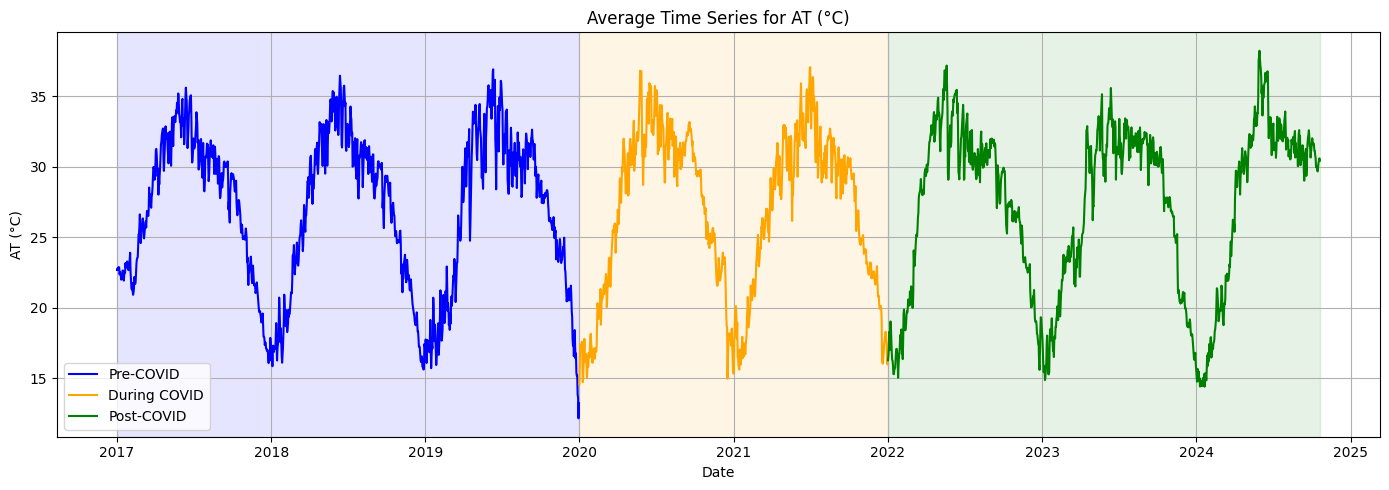

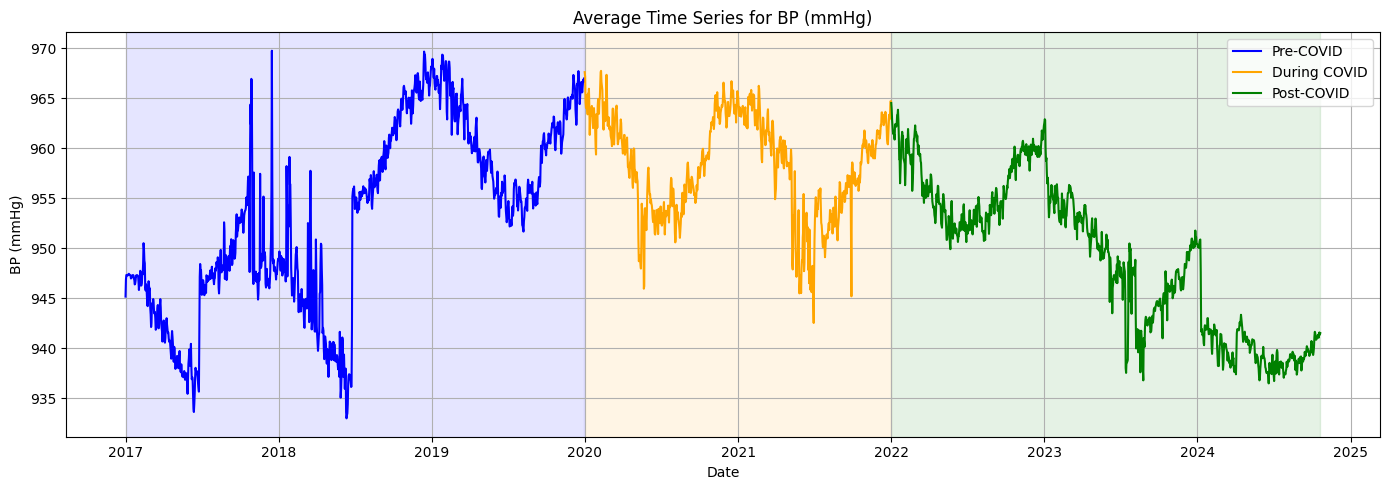

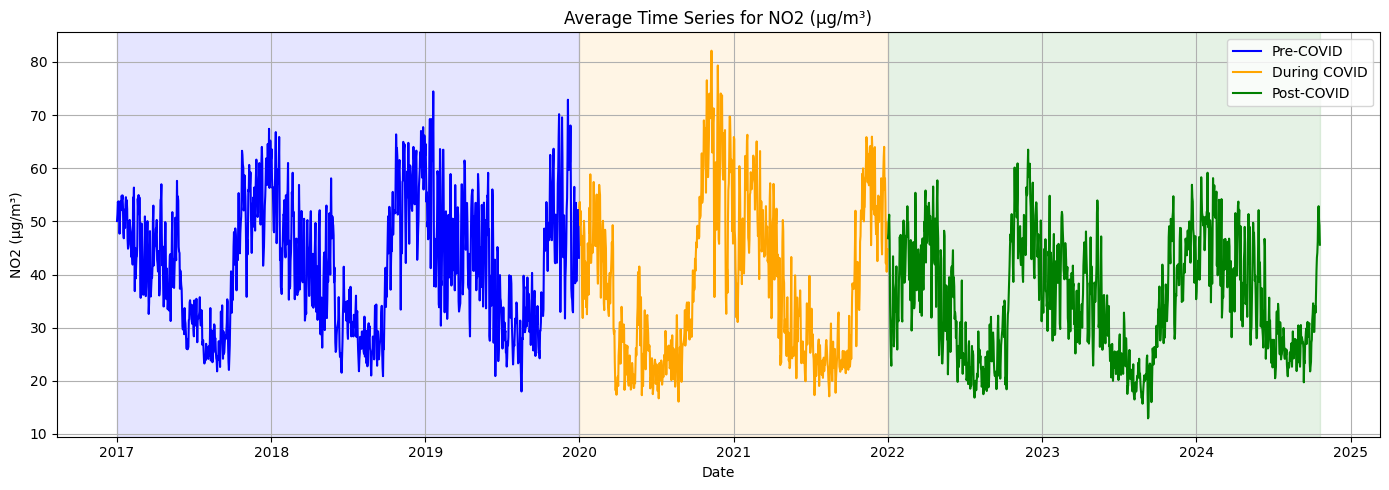

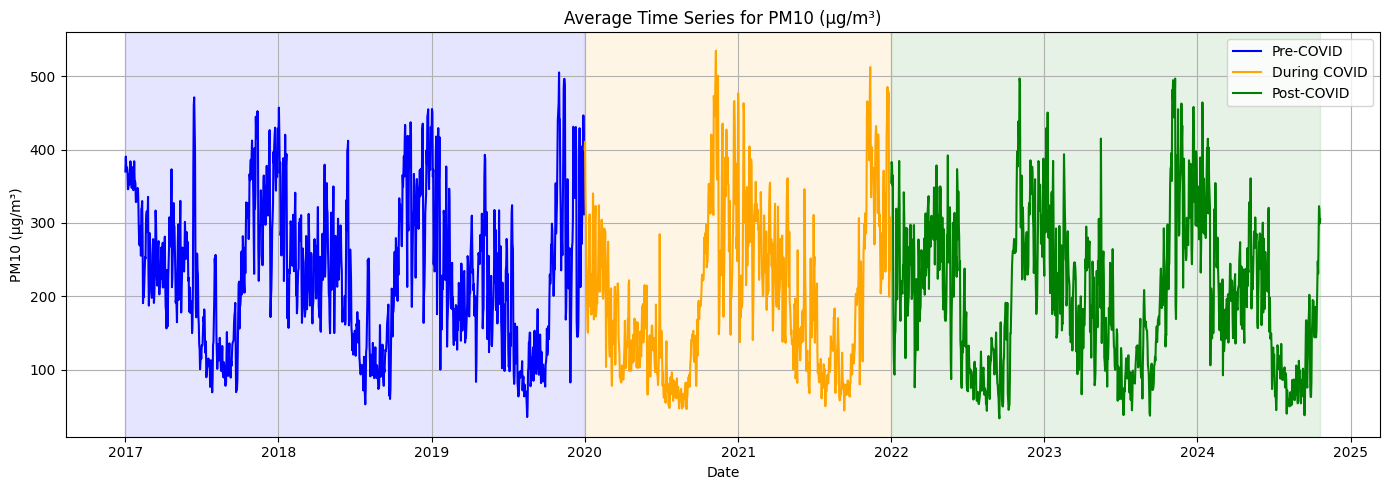

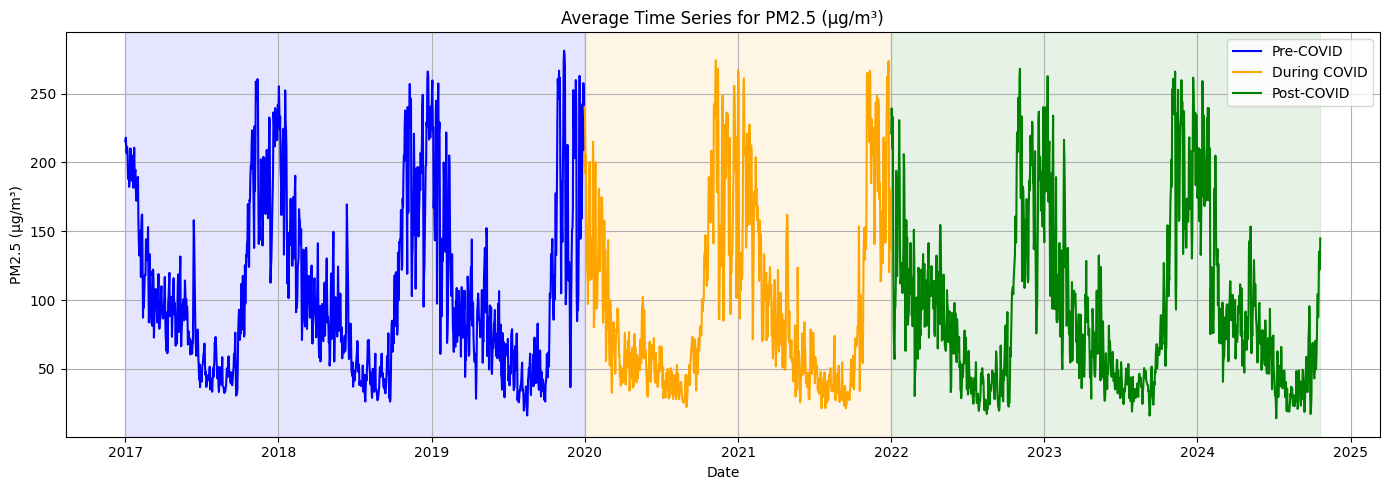

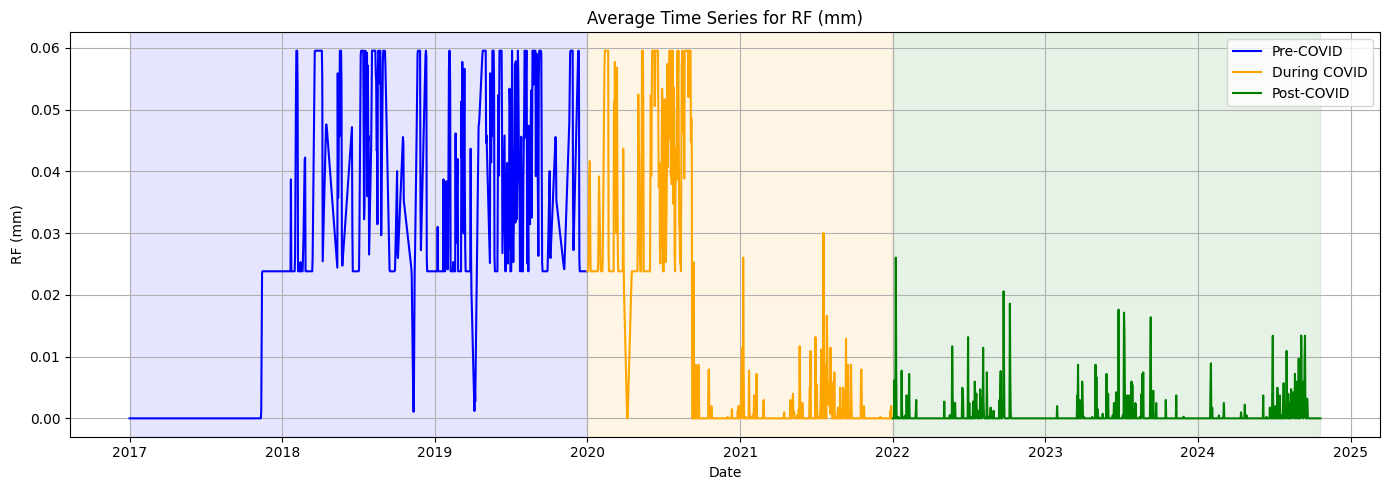

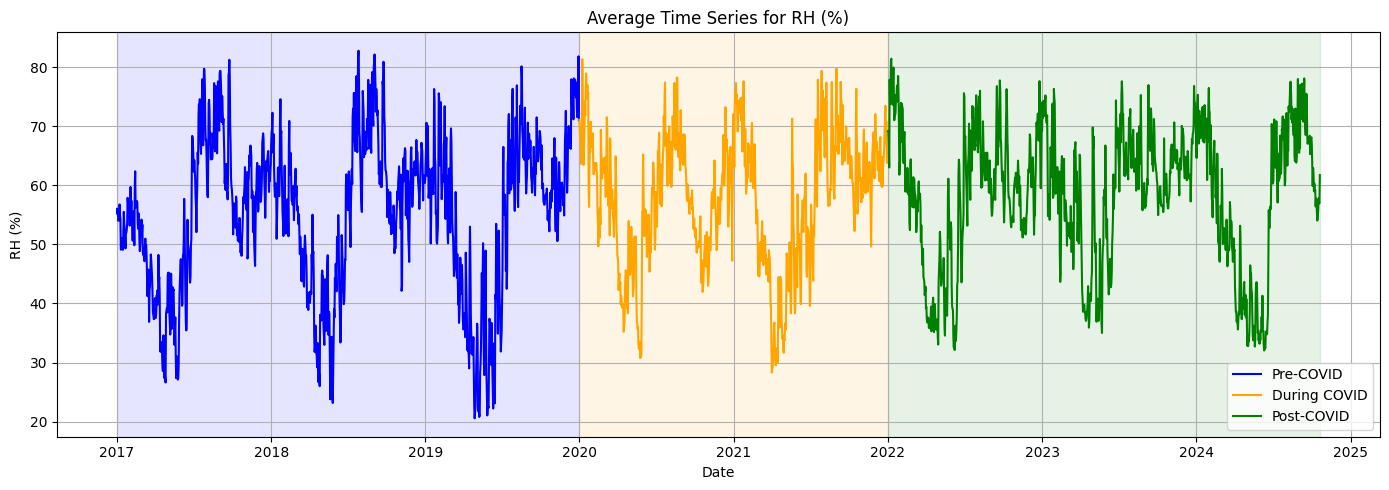

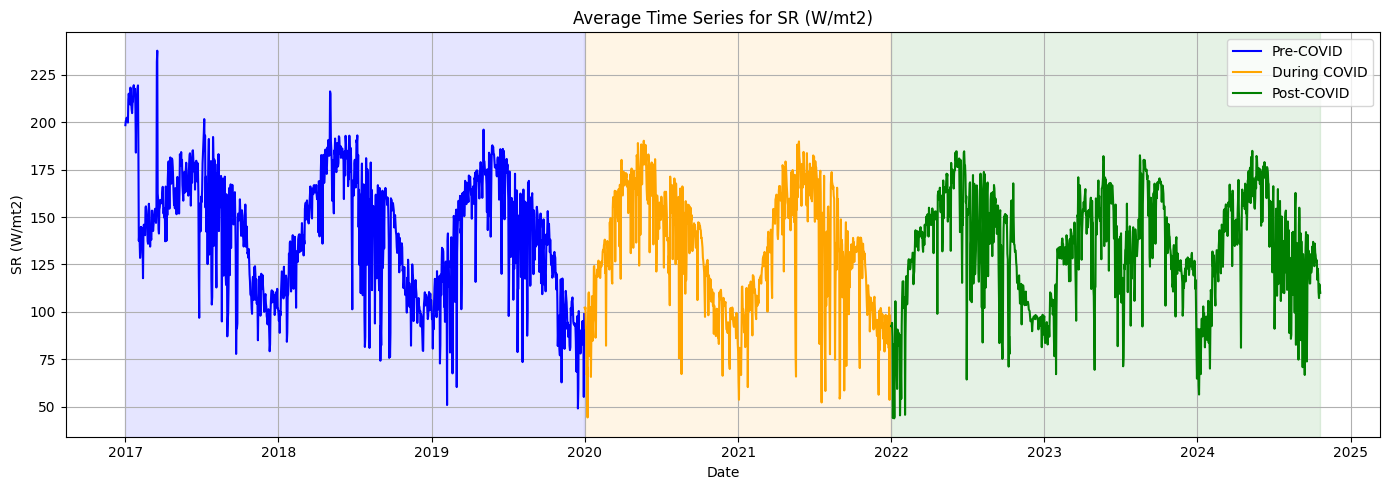

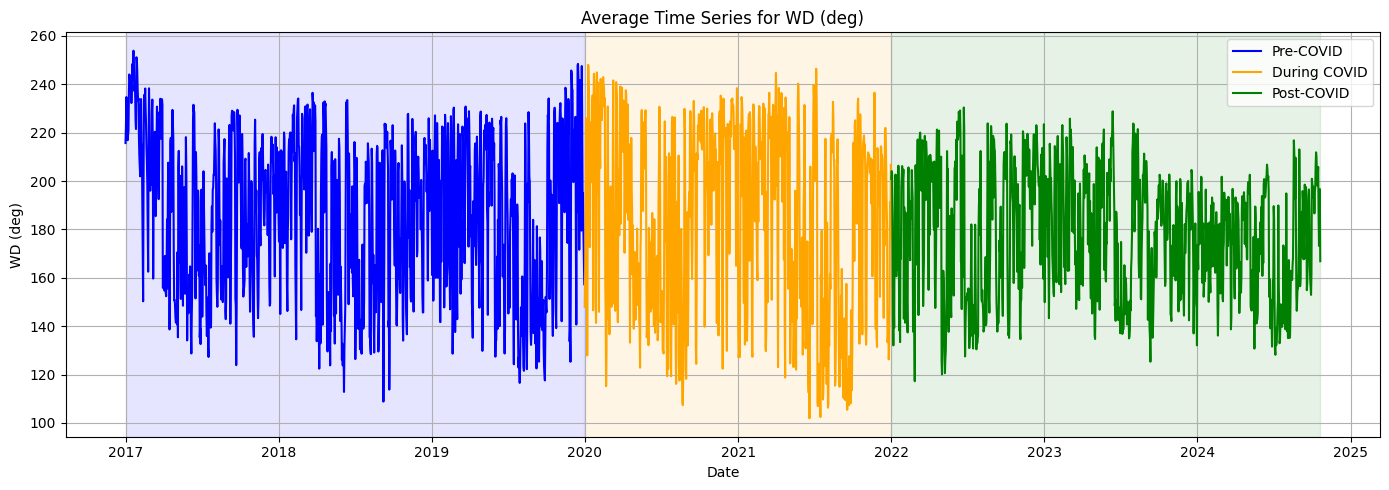

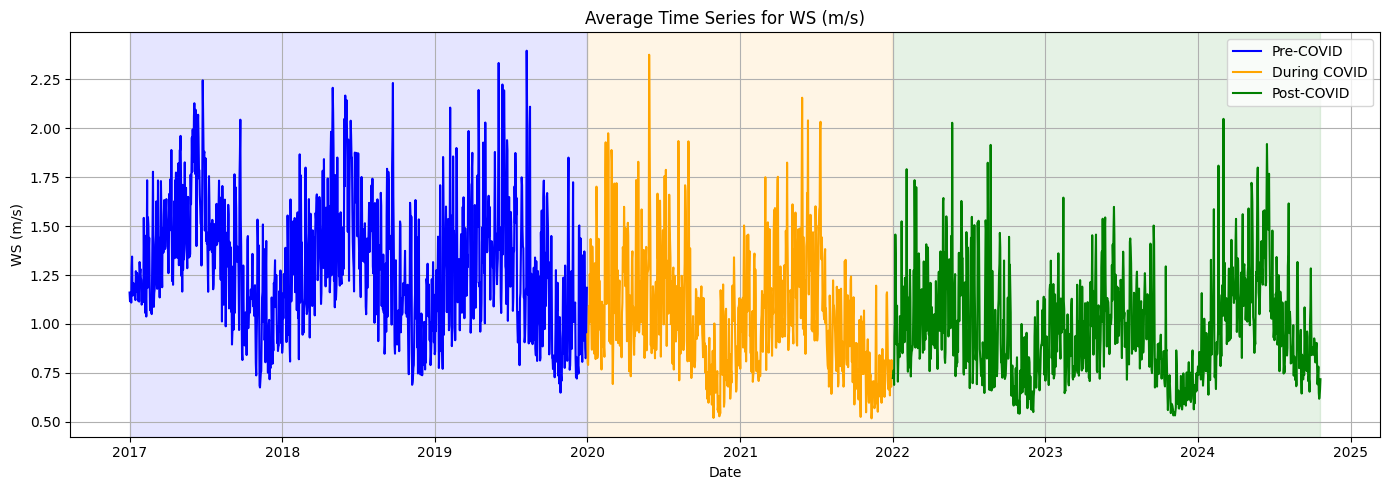

In [15]:


# Only convert and set Timestamp if it's still a column
if 'Timestamp' in preprocessed_df.columns:
    preprocessed_df['Timestamp'] = pd.to_datetime(preprocessed_df['Timestamp'])
    preprocessed_df.set_index('Timestamp', inplace=True)
else:
    preprocessed_df.index = pd.to_datetime(preprocessed_df.index)
# Step 2: Define columns to exclude
exclude_suffixes = ['.1', 'hour_weight', 'month_weight', 'of_week']

# Step 3: Extract unique, clean parameter names
parameter_set = set()
for col in preprocessed_df.columns:
    if '_' in col and not any(ex in col for ex in exclude_suffixes):
        _, param = col.split('_', 1)
        parameter_set.add(param.strip())

print("Filtered Unique Parameters:")
for param in sorted(parameter_set):
    print(param)

# Step 4: Resample for daily or monthly average
avg_type = 'D'  # 'M' for monthly
resampled_df = preprocessed_df.resample(avg_type).mean()

# Step 5: Plot each parameter
for param in sorted(parameter_set):
    matching_cols = [col for col in resampled_df.columns if col.endswith(param) and not any(ex in col for ex in exclude_suffixes)]
    if not matching_cols:
        continue

    param_avg = resampled_df[matching_cols].mean(axis=1)
    if param_avg.isna().all():
        continue

    # Split COVID timeline
    pre_covid = param_avg[param_avg.index < '2020-01-01']
    during_covid = param_avg[(param_avg.index >= '2020-01-01') & (param_avg.index < '2022-01-01')]
    post_covid = param_avg[param_avg.index >= '2022-01-01']

    # Plotting
    plt.figure(figsize=(14, 5))
    plt.plot(pre_covid.index, pre_covid, label='Pre-COVID', color='blue')
    plt.plot(during_covid.index, during_covid, label='During COVID', color='orange')
    plt.plot(post_covid.index, post_covid, label='Post-COVID', color='green')

    plt.axvspan(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-12-31'), alpha=0.1, color='blue')
    plt.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-12-31'), alpha=0.1, color='orange')
    plt.axvspan(pd.to_datetime('2022-01-01'), param_avg.index.max(), alpha=0.1, color='green')

    plt.title(f"Average Time Series for {param}")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning:

invalid value encountered in divide

c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning:

invalid value encountered in divide

c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning:

invalid value encountered in divide

c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning:

invalid value encountered in divide

c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning:

invalid value encountered in divide

c:\Users\jains\OneDrive\Desktop\coding\tf-gpu-env\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning:

invalid value encountered in divide

c:\Users\jains\OneDrive\Desktop\co


Best stations from each cluster:
                         Station  Cluster  AvgAbsCorr
Dwarka-Sector 8  Dwarka-Sector 8        0    0.308363
Chandni Chowk      Chandni Chowk        1    0.223035
Alipur                    Alipur        2    0.223694

Cluster centers in PCA space:
[[-1.01102429  0.19796075]
 [ 2.44958112  0.13624766]
 [-0.81472    -5.38340469]]


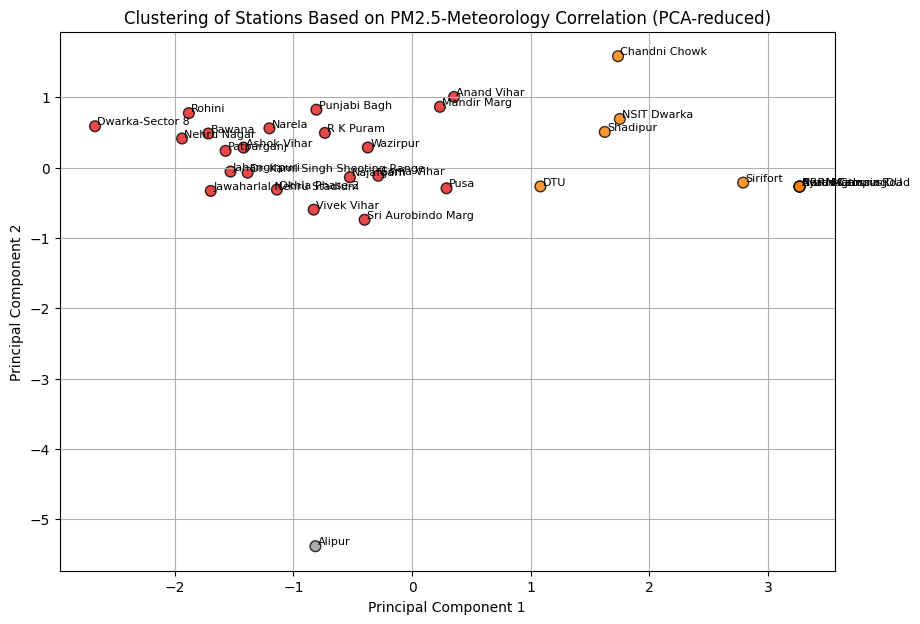

In [16]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load dataset (already preprocessed)
df = preprocessed_df.copy()  # 'preprocessed_df' should already exist with timestamp as index

# Extract unique station names
stations = sorted(set(col.split('_')[0] for col in df.columns if '_' in col))

# Define meteorological parameters to correlate with PM2.5
meteo_suffixes = ['AT (°C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'BP (mmHg)', 'RF (mm)', 'SR (W/mt2)']

# Step 1: Compute correlation vectors for each station
corr_data = {}

for station in stations:
    pm25_col = f"{station}_PM2.5 (µg/m³)"
    if pm25_col not in df.columns:
        continue

    corr_vector = []
    for suffix in meteo_suffixes:
        feature_col = f"{station}_{suffix}"
        if feature_col in df.columns:
            valid_data = df[[pm25_col, feature_col]].dropna()
            if len(valid_data) > 1:
                corr = valid_data[pm25_col].corr(valid_data[feature_col])
                corr_vector.append(corr)
            else:
                corr_vector.append(0)
        else:
            corr_vector.append(0)
    
    corr_data[station] = corr_vector

# Step 2: Convert to DataFrame
corr_df = pd.DataFrame.from_dict(corr_data, orient='index', columns=meteo_suffixes)
corr_df.fillna(0, inplace=True)

# Step 3: Drop constant or NaN columns before scaling
stds = corr_df.std()
zero_std_cols = stds[stds == 0].index.tolist()
corr_df = corr_df.drop(columns=zero_std_cols)

# Step 4: Scale correlation vectors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(corr_df)

# Step 5: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 6: Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Step 7: Add cluster and station info back
corr_df['Cluster'] = clusters
corr_df['Station'] = corr_df.index
corr_df['AvgAbsCorr'] = corr_df.drop(columns=['Cluster', 'Station']).abs().mean(axis=1)

# Step 8: Identify best representative station in each cluster
best_stations = corr_df.loc[corr_df.groupby('Cluster')['AvgAbsCorr'].idxmax()][['Station', 'Cluster', 'AvgAbsCorr']]

# Step 9: Final station-cluster mapping
station_scores = corr_df[['Station', 'Cluster']].rename(columns={'Station': 'Main_Station'}).reset_index(drop=True)

# Step 10: Output results
print("\nBest stations from each cluster:")
print(best_stations[['Station', 'Cluster', 'AvgAbsCorr']])

print("\nCluster centers in PCA space:")
print(kmeans.cluster_centers_)

# Step 11: Visualize clusters
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1', s=60, alpha=0.8, edgecolors='k')
for i, station in enumerate(corr_df['Station']):
    plt.text(X_pca[i, 0]+0.02, X_pca[i, 1]+0.02, station, fontsize=8)
plt.title("Clustering of Stations Based on PM2.5-Meteorology Correlation (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [17]:
print(station_scores)

                      Main_Station  Cluster
0                           Alipur        2
1                      Anand Vihar        0
2                      Ashok Vihar        0
3                        Aya Nagar        1
4                           Bawana        0
5                  Burari Crossing        1
6                CRRI Mathura Road        1
7                    Chandni Chowk        1
8                              DTU        1
9   Dr. Karni Singh Shooting Range        0
10                 Dwarka-Sector 8        0
11                    Jahangirpuri        0
12        Jawaharlal Nehru Stadium        0
13                     Mandir Marg        0
14                     NSIT Dwarka        1
15                       Najafgarh        0
16                          Narela        0
17                     Nehru Nagar        0
18                 North Campus DU        1
19                   Okhla Phase-2        0
20                      Patparganj        0
21                    Punjabi Ba

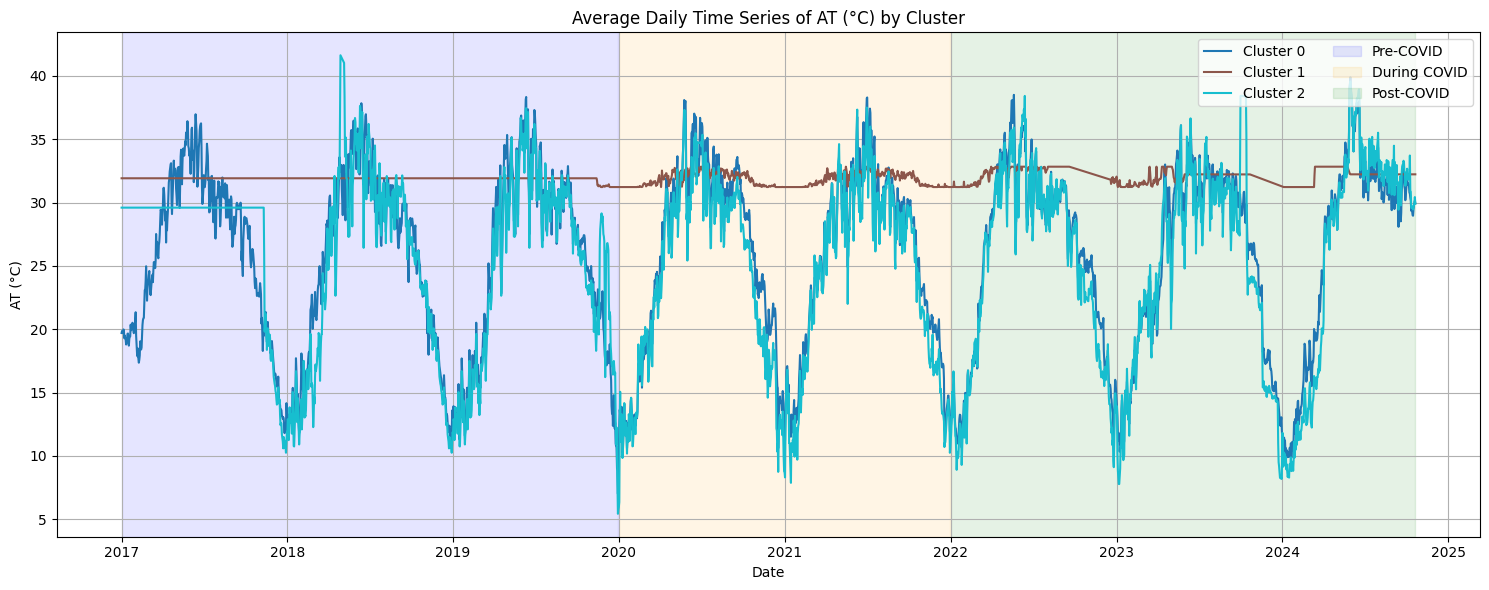

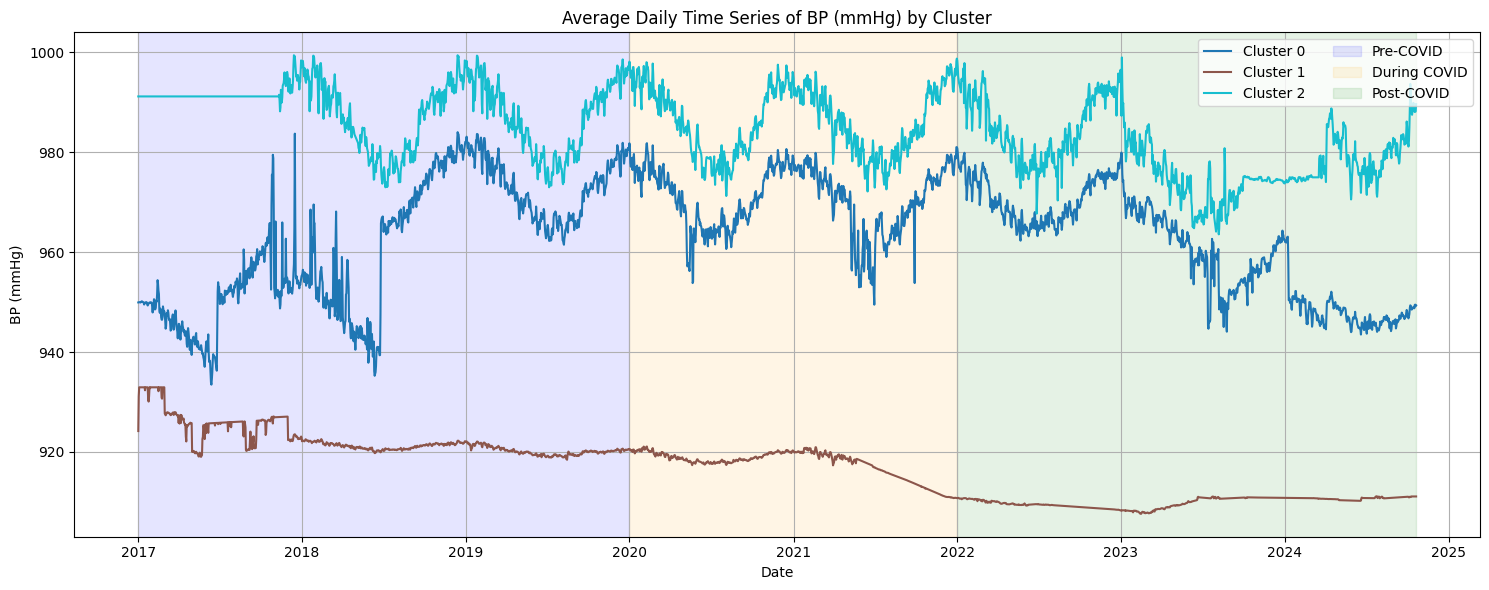

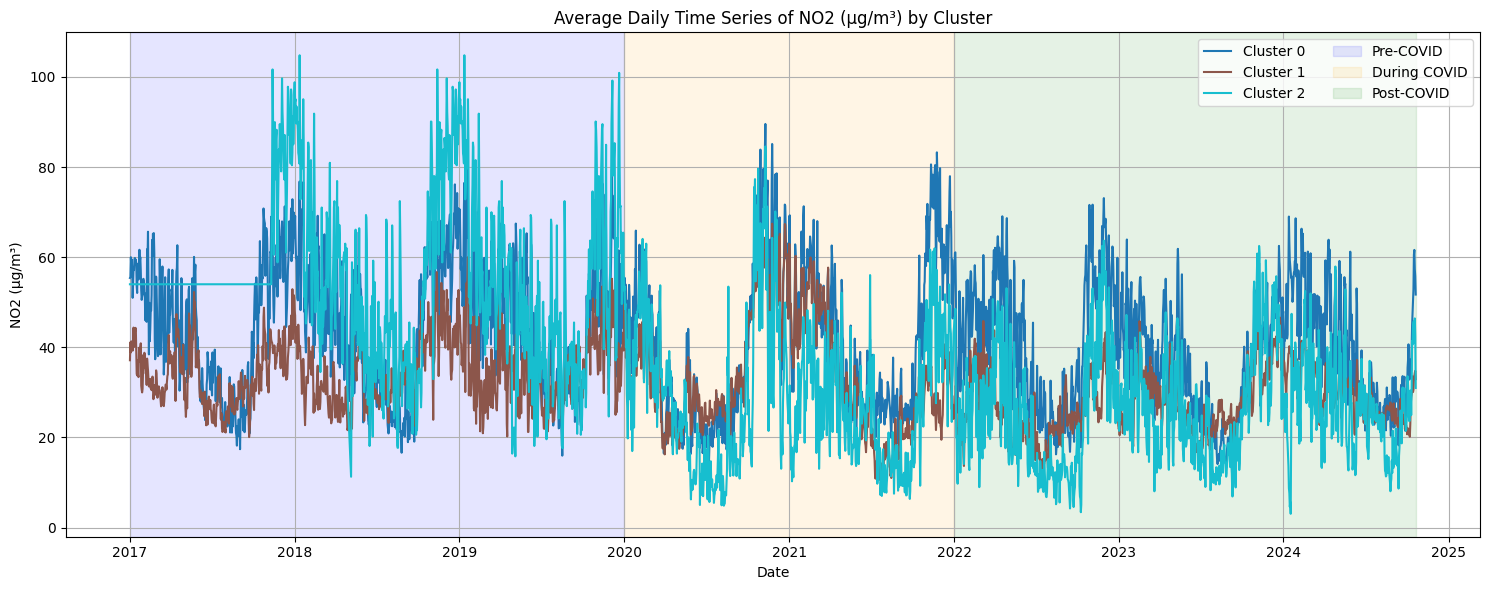

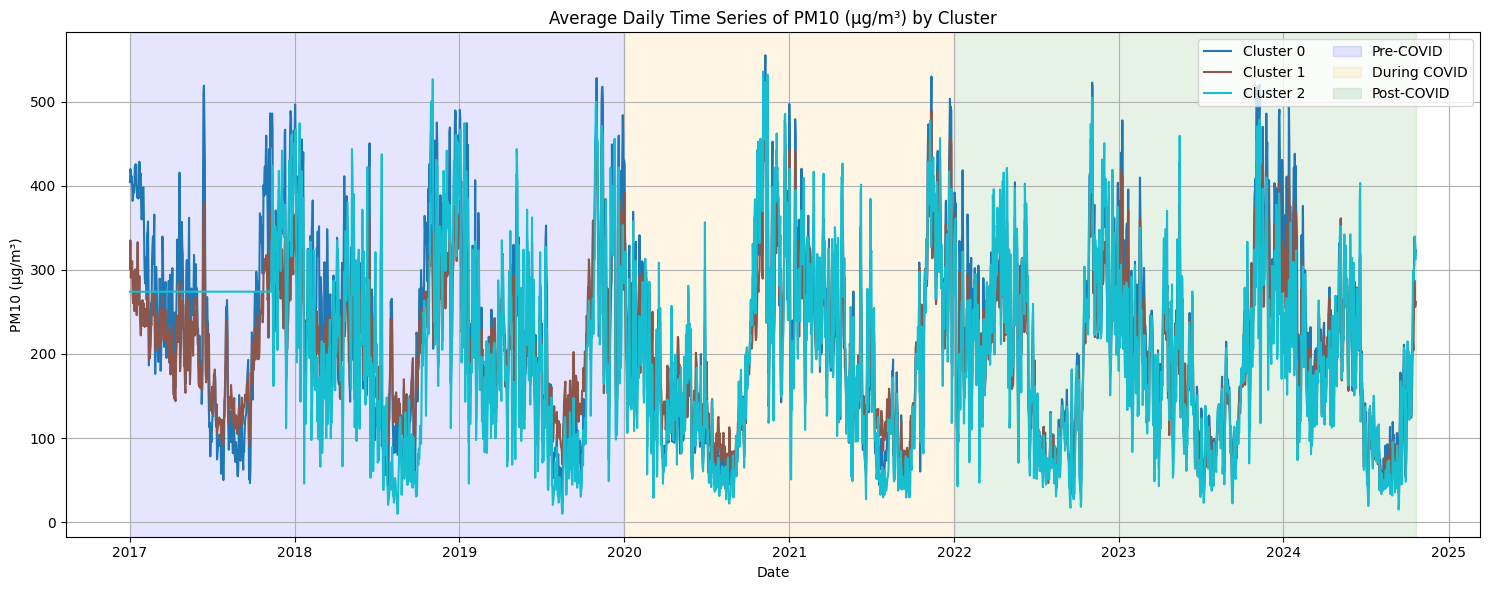

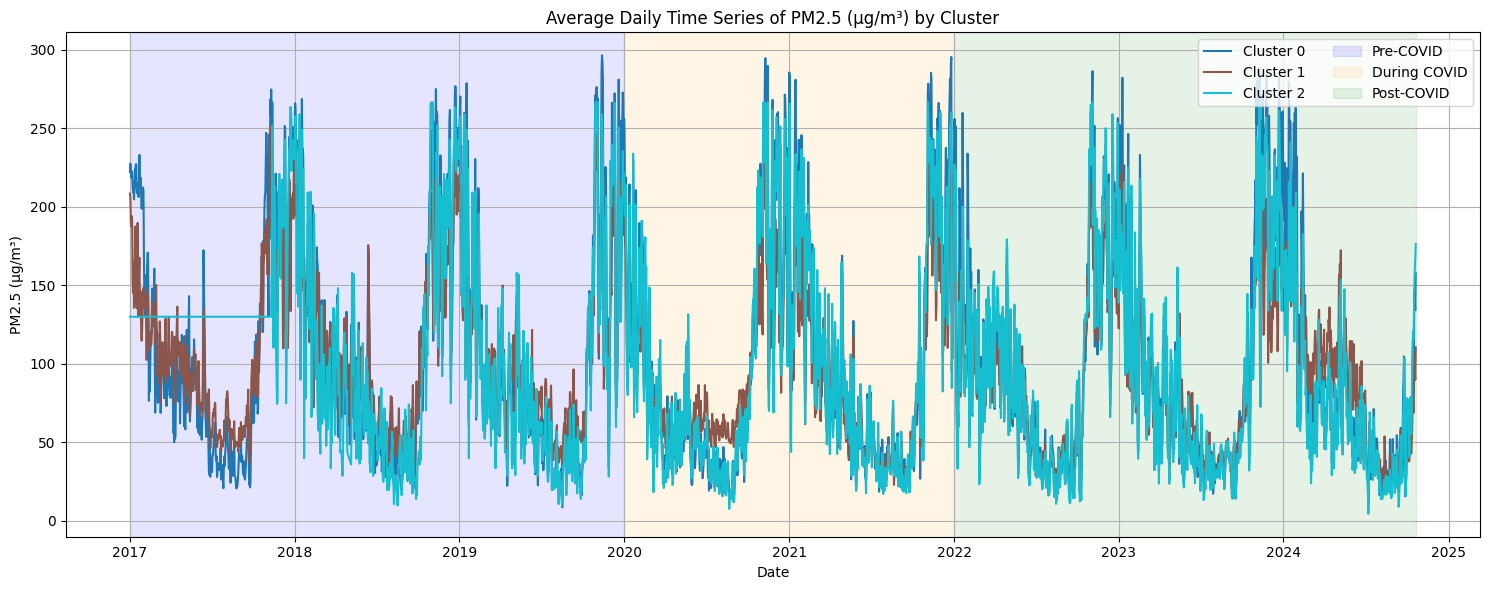

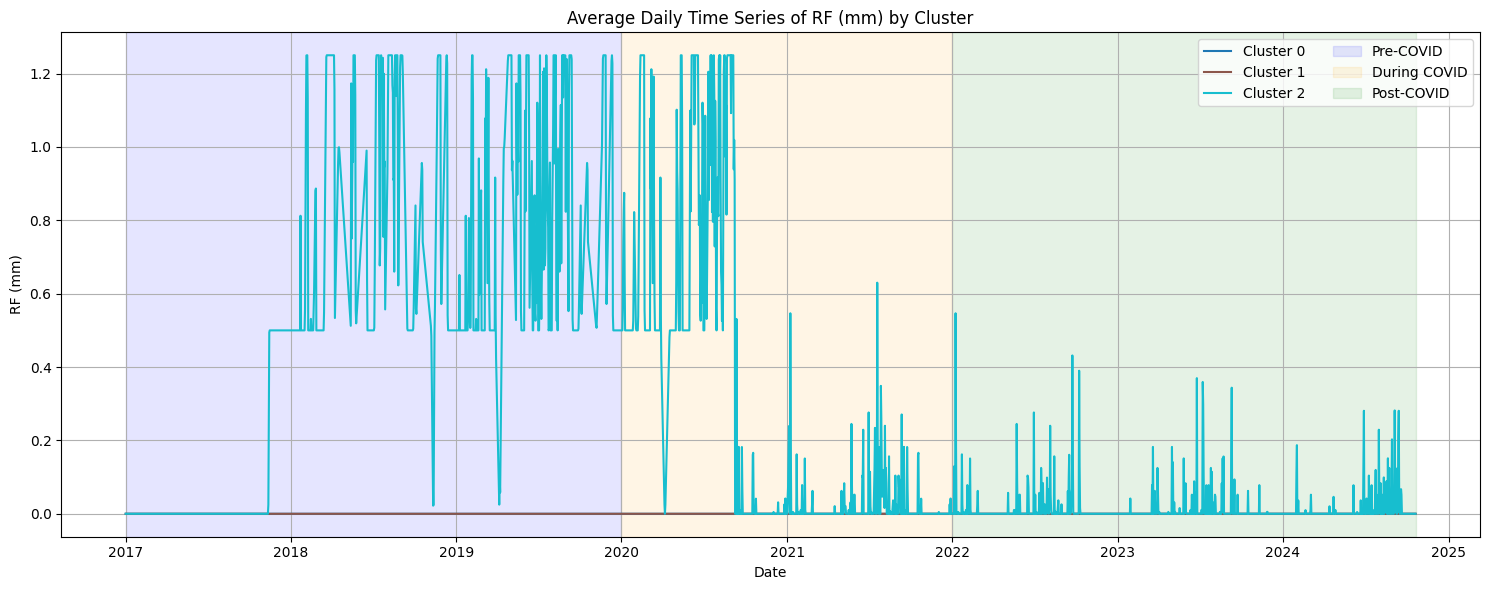

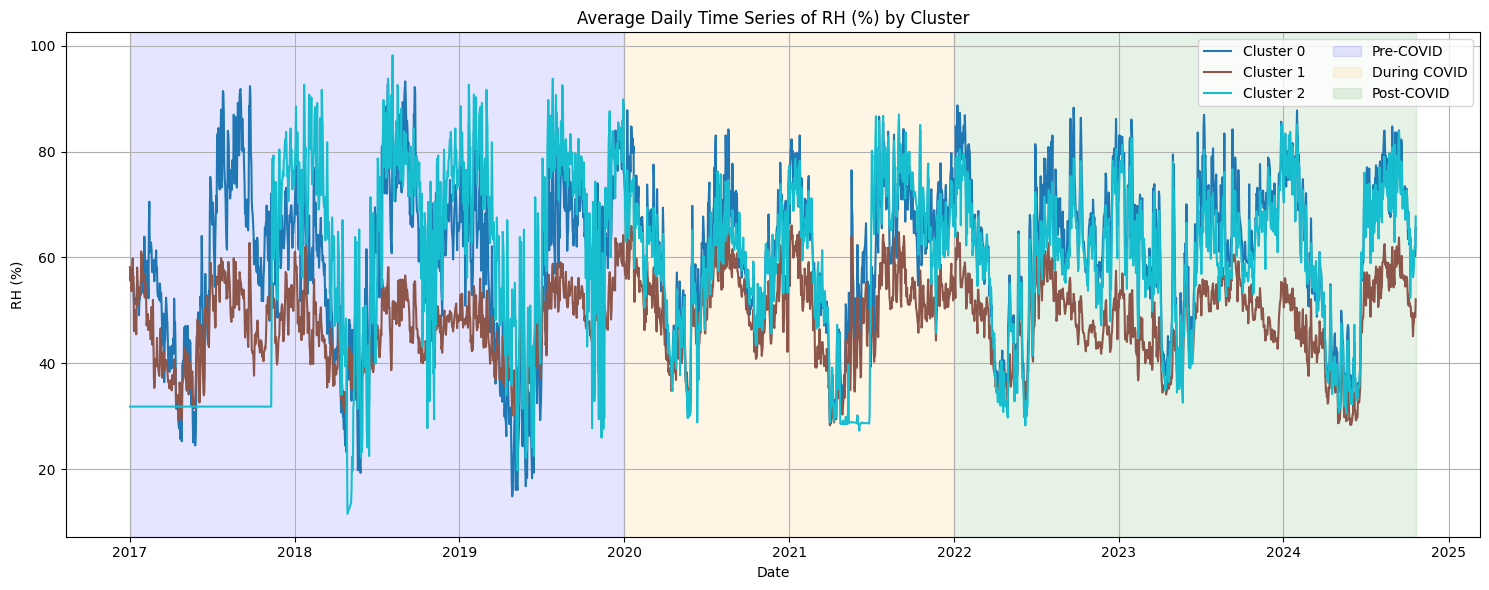

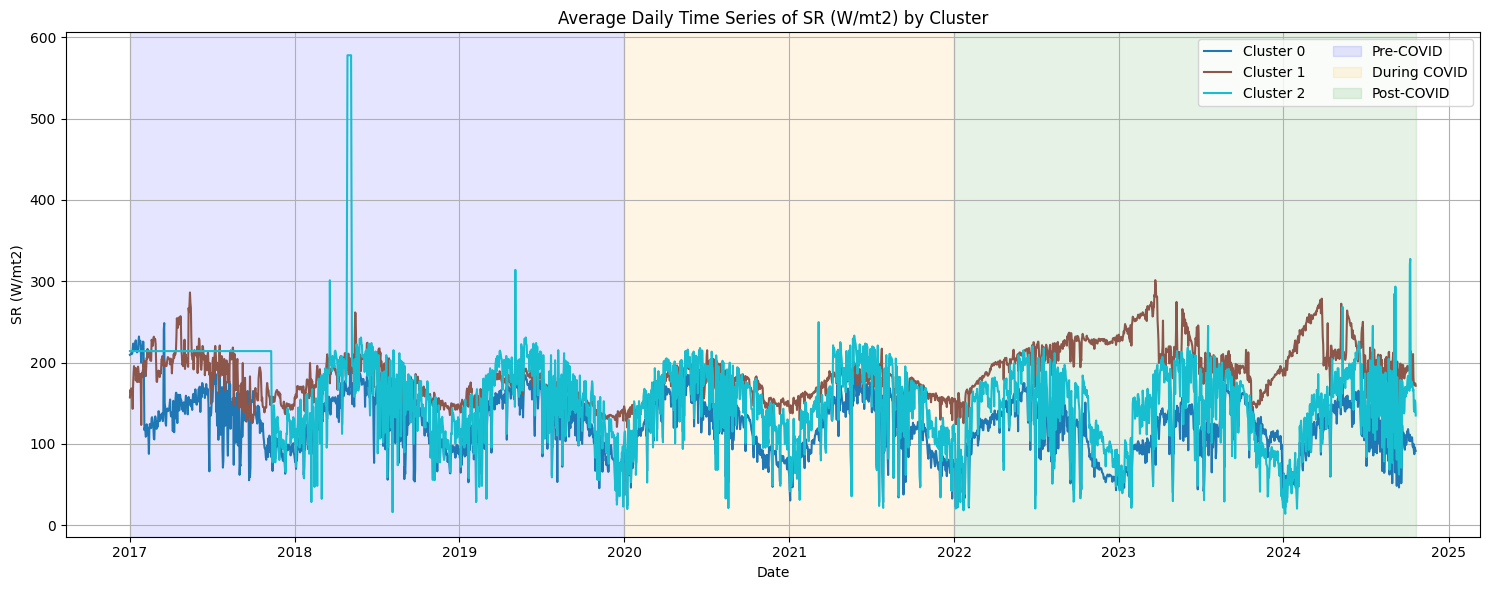

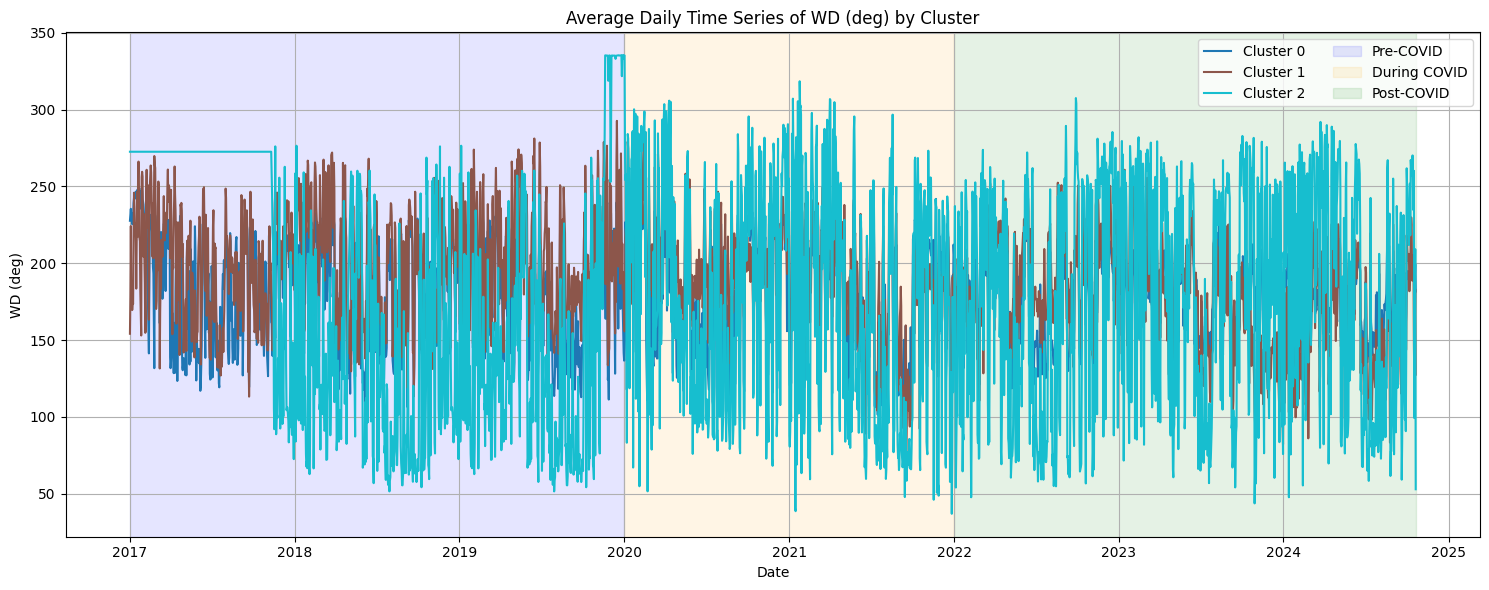

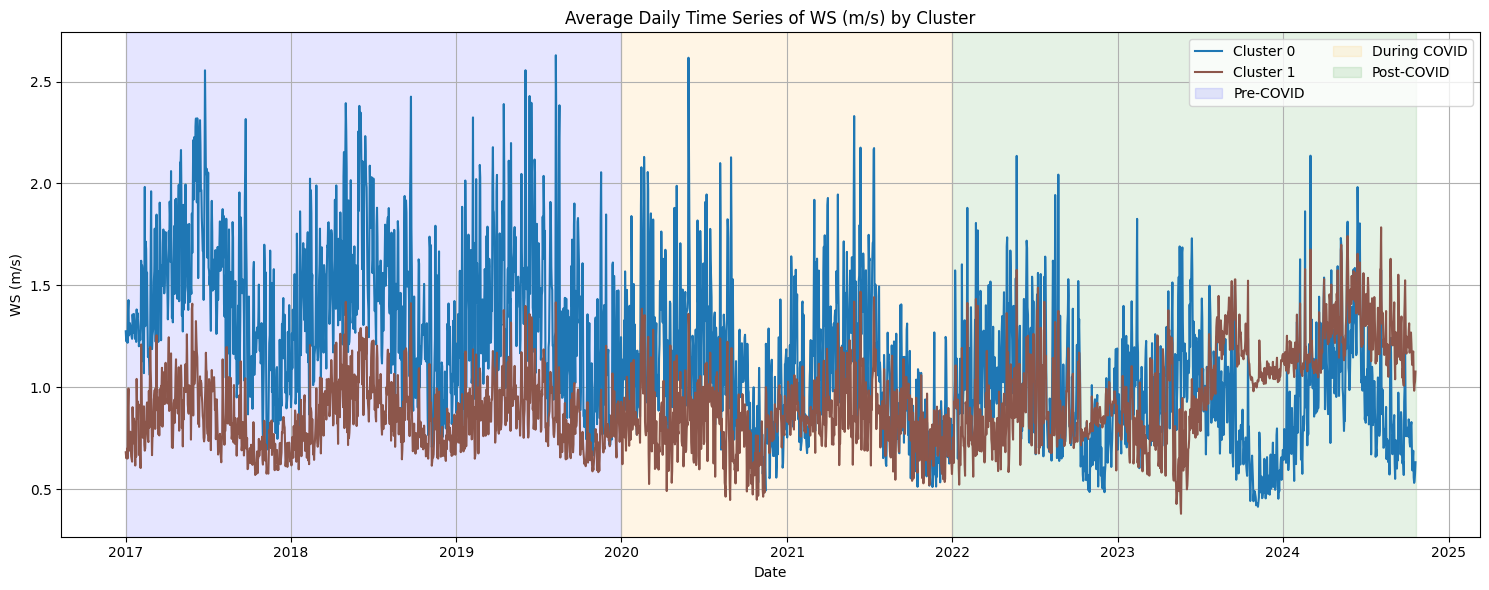

In [18]:
#cluster wise parameter analysis
import matplotlib.cm as cm
from collections import defaultdict

# Step 1: Ensure datetime index
preprocessed_df.index = pd.to_datetime(preprocessed_df.index)

# Step 2: Clean and map station to cluster
station_scores.columns = station_scores.columns.str.strip().str.lower()
station_cluster_map = dict(zip(station_scores['main_station'], station_scores['cluster']))

# Step 3: Reverse mapping of clusters to station names
cluster_to_stations = defaultdict(list)
for station, cluster in station_cluster_map.items():
    cluster_to_stations[cluster].append(station)

# Step 4: Extract all unique parameters (ignoring .1 and weights)
valid_columns = [col for col in preprocessed_df.columns if '_' in col and not col.endswith(('.1', 'hour_weight', 'month_weight', 'of_week'))]
unique_params = sorted(set(col.split('_', 1)[1] for col in valid_columns))

# Step 5: Daily average
daily_df = preprocessed_df.resample('D').mean()

# Step 6: Colors for clusters
num_clusters = len(cluster_to_stations)
colors = cm.tab10(np.linspace(0, 1, num_clusters))

# Step 7: Iterate through each unique parameter
for param in unique_params:
    plt.figure(figsize=(15, 6))

    found = False  # flag to avoid plotting empty plots

    # Plot each cluster
    for i, (cluster, stations) in enumerate(sorted(cluster_to_stations.items())):
        # Get columns for this parameter and cluster stations
        matching_cols = [f"{station}_{param}" for station in stations if f"{station}_{param}" in daily_df.columns]
        if not matching_cols:
            continue

        # Average the parameter across stations in this cluster
        cluster_avg = daily_df[matching_cols].mean(axis=1)
        if cluster_avg.dropna().empty:
            continue

        found = True
        plt.plot(cluster_avg.index, cluster_avg, label=f"Cluster {cluster}", color=colors[i])

    if not found:
        plt.close()
        continue

    # Add COVID period shading
    plt.axvspan(pd.to_datetime('2017-01-01'), pd.to_datetime('2019-12-31'), alpha=0.1, color='blue', label='Pre-COVID')
    plt.axvspan(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-12-31'), alpha=0.1, color='orange', label='During COVID')
    plt.axvspan(pd.to_datetime('2022-01-01'), cluster_avg.index.max(), alpha=0.1, color='green', label='Post-COVID')

    # Labels and legend
    plt.title(f"Average Daily Time Series of {param} by Cluster")
    plt.xlabel("Date")
    plt.ylabel(param)
    plt.grid(True)
    plt.legend(loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()


In [19]:
import plotly.express as px

# Load location data
location_df = pd.read_csv(r'C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\location.csv')
location_df.columns = location_df.columns.str.strip().str.lower()

# Clean column names
station_scores.columns = station_scores.columns.str.strip().str.lower()

# Merge with location data
merged_df = pd.merge(
    station_scores,
    location_df,
    how='left',
    left_on='main_station',
    right_on='location'
)

# Drop rows with missing lat/lon
merged_df = merged_df.dropna(subset=['latitudes', 'longitudes'])

# Define your custom color sequence (categorical)
custom_colors = px.colors.qualitative.Set2  # You can try: Set1, Set3, Dark2, Pastel1, etc.

# Plot with discrete color palette
fig = px.scatter_mapbox(
    merged_df,
    lat="latitudes",
    lon="longitudes",
    color="cluster",
    text="main_station",
    zoom=10,
    height=800,
    width=900,
    mapbox_style="open-street-map",
    color_discrete_sequence=custom_colors  # <-- Use this instead
)

# Update hover and marker size
fig.update_traces(
    marker=dict(size=12),
    hovertemplate='<b>%{text}</b><br>Cluster: %{marker.color}'
)

# Final layout
fig.update_layout(
    title="Delhi AQI Stations Clustered by Weighted MI Score",
    title_x=0.5,
    margin=dict(l=10, r=10, t=40, b=10)
)

fig.show()


C:\Users\jains\AppData\Local\Temp\ipykernel_31840\358752061.py:26: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [20]:
from xgboost import XGBRegressor


In [25]:
DATA_FILE = r"C:\Users\jains\OneDrive\Desktop\AQI_PROJECT\results\preprocessed_all_station_data_withouknn.csv"

In [26]:
# Load core datasets
df = pd.read_csv(DATA_FILE)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])


# Model dictionary
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}


In [27]:
all_results = []
all_feature_importance = []

for cluster_id in sorted(station_scores['cluster'].unique()):
    stations_in_cluster = station_scores[station_scores['cluster'] == cluster_id]['main_station'].tolist()
    print(f"\n--- Cluster {cluster_id}: {len(stations_in_cluster)} stations ---")

    for station in stations_in_cluster:
        target_col = f"{station}_PM2.5 (µg/m³)"
        if target_col not in df.columns:
            print(f"Skipping {station} - target not found.")
            continue

        # Basic time-based features
        df_station = df[['Timestamp', target_col, 'month', 'day_of_week', 'hour',
                         'PM2.5_month_weight', 'PM2.5_hour_weight']].copy()

        # Add main station's own meteorological features (excluding PM10 and target)
        for col in df.columns:
            if col.startswith(f"{station}_") and col != target_col and "PM10" not in col:
                df_station[col] = df[col]

        # Drop missing values and sort
        df_station = df_station.dropna().sort_values('Timestamp')

        # Define X and y
        X = df_station.drop(columns=['Timestamp', target_col])
        y = df_station[target_col]

        # Train/test split
        train_mask = df_station['Timestamp'] < '2024-01-01'
        test_mask = df_station['Timestamp'] >= '2024-01-01'
        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]

        # Train each model
        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred_test = model.predict(X_test)

            # Store results
            all_results.append({
            'Cluster': cluster_id,
            'Station': station,
            'Model': name,
            'Train_R2': r2_score(y_train, model.predict(X_train)),
            'Test_R2': r2_score(y_test, y_pred_test)
                })


            # Store feature importance (if applicable)
            if hasattr(model, 'feature_importances_'):
                all_feature_importance.append(pd.DataFrame({
                    'Cluster': cluster_id,
                    'Station': station,
                    'Model': name,
                    'Feature': X.columns,
                    'Importance': model.feature_importances_
                }))



--- Cluster 0: 21 stations ---

--- Cluster 1: 9 stations ---

--- Cluster 2: 1 stations ---


In [28]:
print(all_results)

[{'Cluster': np.int32(0), 'Station': 'Anand Vihar', 'Model': 'Decision Tree', 'Train_R2': 1.0, 'Test_R2': -0.11491636638542158}, {'Cluster': np.int32(0), 'Station': 'Anand Vihar', 'Model': 'Random Forest', 'Train_R2': 0.9764020267777903, 'Test_R2': 0.3510323350320066}, {'Cluster': np.int32(0), 'Station': 'Anand Vihar', 'Model': 'XGBoost', 'Train_R2': 0.8502322341715868, 'Test_R2': 0.41472009300490287}, {'Cluster': np.int32(0), 'Station': 'Ashok Vihar', 'Model': 'Decision Tree', 'Train_R2': 1.0, 'Test_R2': 0.07757848854531824}, {'Cluster': np.int32(0), 'Station': 'Ashok Vihar', 'Model': 'Random Forest', 'Train_R2': 0.9837562756277789, 'Test_R2': 0.5563500008298863}, {'Cluster': np.int32(0), 'Station': 'Ashok Vihar', 'Model': 'XGBoost', 'Train_R2': 0.8747914231907081, 'Test_R2': 0.4837350884612469}, {'Cluster': np.int32(0), 'Station': 'Bawana', 'Model': 'Decision Tree', 'Train_R2': 1.0, 'Test_R2': 0.053183631405134046}, {'Cluster': np.int32(0), 'Station': 'Bawana', 'Model': 'Random Fores

In [29]:


# Assuming `all_results` is the list you populated earlier
results_df = pd.DataFrame(all_results)

# Quick check
print(results_df.head())


   Cluster      Station          Model  Train_R2   Test_R2
0        0  Anand Vihar  Decision Tree  1.000000 -0.114916
1        0  Anand Vihar  Random Forest  0.976402  0.351032
2        0  Anand Vihar        XGBoost  0.850232  0.414720
3        0  Ashok Vihar  Decision Tree  1.000000  0.077578
4        0  Ashok Vihar  Random Forest  0.983756  0.556350


In [30]:
# Convert results_df if not already a DataFrame
# results_df = pd.DataFrame(all_results)

for cluster_id in sorted(results_df['Cluster'].unique()):
    cluster_data = results_df[results_df['Cluster'] == cluster_id]
    print(f"\n=== Cluster {cluster_id} ===")
    print(cluster_data[['Station', 'Model', 'Train_R2', 'Test_R2']]
          .sort_values(['Station', 'Model'])
          .to_string(index=False))



=== Cluster 0 ===
                       Station         Model  Train_R2   Test_R2
                   Anand Vihar Decision Tree  1.000000 -0.114916
                   Anand Vihar Random Forest  0.976402  0.351032
                   Anand Vihar       XGBoost  0.850232  0.414720
                   Ashok Vihar Decision Tree  1.000000  0.077578
                   Ashok Vihar Random Forest  0.983756  0.556350
                   Ashok Vihar       XGBoost  0.874791  0.483735
                        Bawana Decision Tree  1.000000  0.053184
                        Bawana Random Forest  0.979904  0.547765
                        Bawana       XGBoost  0.851956  0.479904
Dr. Karni Singh Shooting Range Decision Tree  1.000000  0.291878
Dr. Karni Singh Shooting Range Random Forest  0.980006  0.661603
Dr. Karni Singh Shooting Range       XGBoost  0.858371  0.628374
               Dwarka-Sector 8 Decision Tree  1.000000  0.178756
               Dwarka-Sector 8 Random Forest  0.980275  0.528896
      

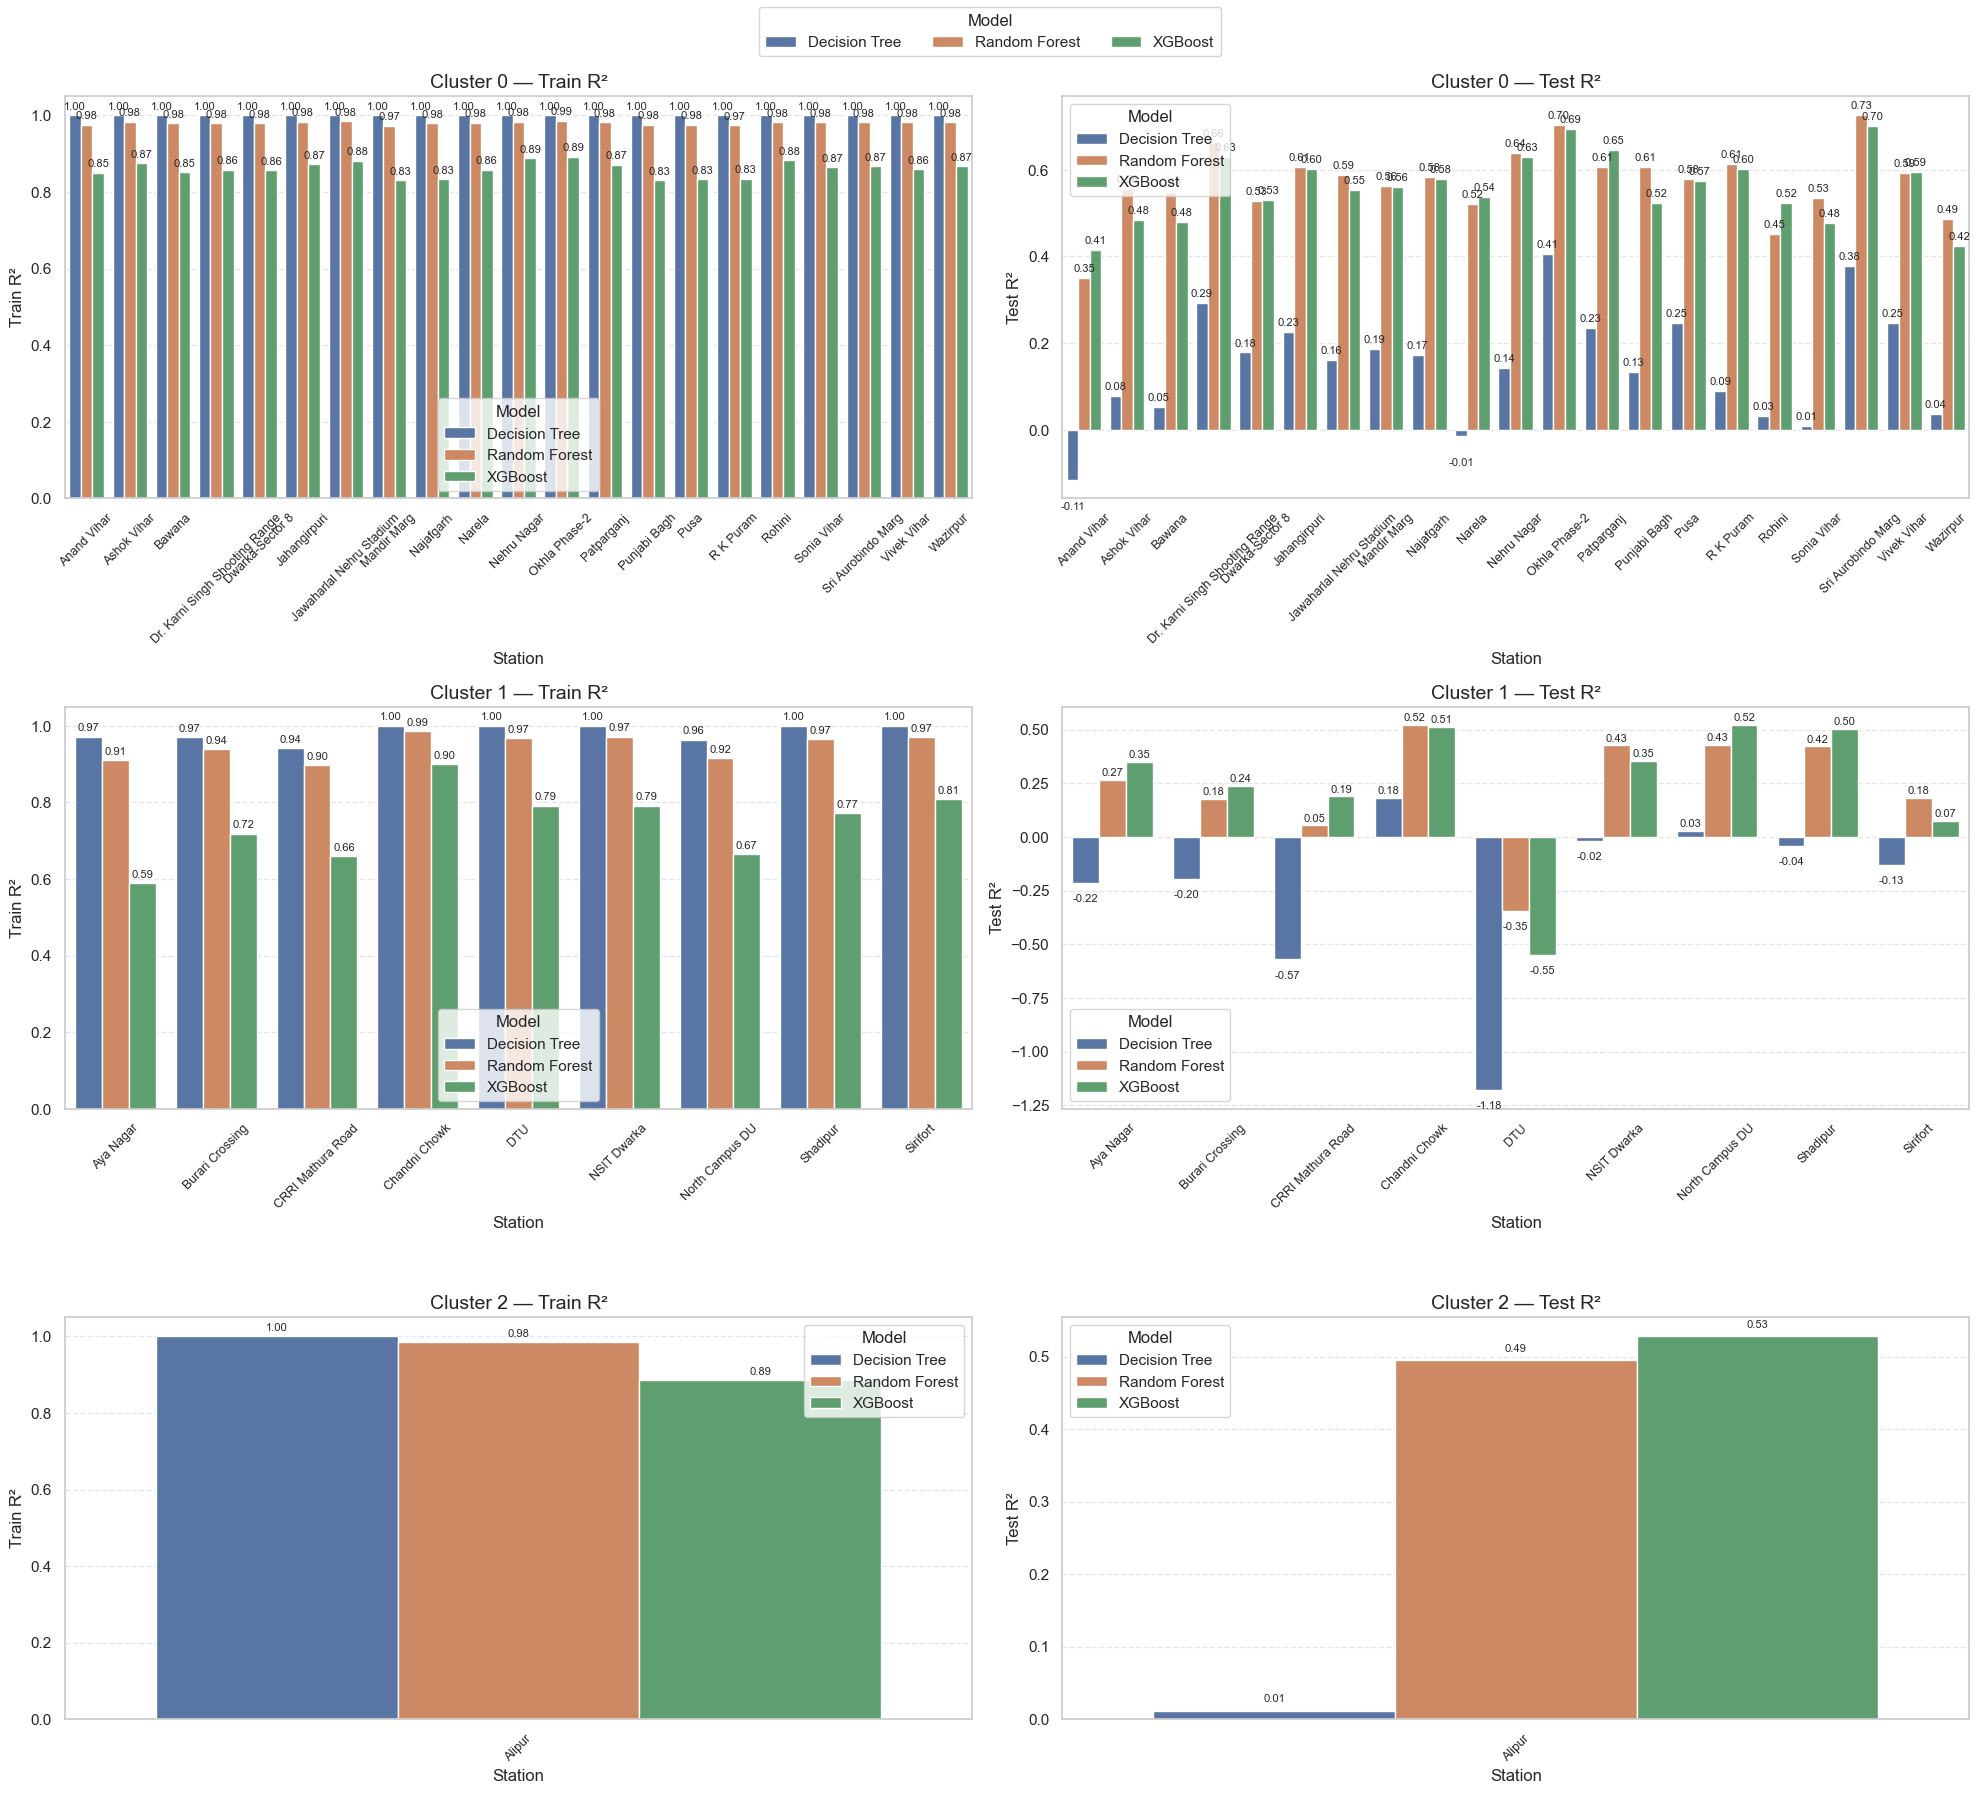

In [31]:


# Set style
sns.set(style="whitegrid")

clusters = sorted(results_df['Cluster'].unique())
n_clusters = len(clusters)

# Configure figure
fig, axes = plt.subplots(nrows=n_clusters, ncols=2, figsize=(20, 6 * n_clusters), squeeze=False)
bar_width = 0.6

for i, cluster_id in enumerate(clusters):
    cluster_data = results_df[results_df['Cluster'] == cluster_id]

    # Sort by station for consistent order
    cluster_data = cluster_data.sort_values(['Station', 'Model'])

    # TRAIN plot
    ax_train = axes[i, 0]
    sns.barplot(
        data=cluster_data,
        x='Station',
        y='Train_R2',
        hue='Model',
        ax=ax_train,
        dodge=True
    )
    ax_train.set_title(f"Cluster {cluster_id} — Train R²", fontsize=14)
    ax_train.set_ylabel("Train R²", fontsize=12)
    ax_train.set_xlabel("Station", fontsize=12)
    ax_train.tick_params(axis='x', rotation=45, labelsize=9)
    ax_train.grid(axis='y', linestyle='--', alpha=0.5)

    # Annotate Train R²
    for p in ax_train.patches:
        h = p.get_height()
        if not pd.isna(h) and abs(h) > 0.01:
            ax_train.text(
                p.get_x() + p.get_width() / 2,
                h + 0.01 if h > 0 else h - 0.05,
                f"{h:.2f}",
                ha='center', va='bottom' if h > 0 else 'top',
                fontsize=8, rotation=0
            )

    # TEST plot
    ax_test = axes[i, 1]
    sns.barplot(
        data=cluster_data,
        x='Station',
        y='Test_R2',
        hue='Model',
        ax=ax_test,
        dodge=True
    )
    ax_test.set_title(f"Cluster {cluster_id} — Test R²", fontsize=14)
    ax_test.set_ylabel("Test R²", fontsize=12)
    ax_test.set_xlabel("Station", fontsize=12)
    ax_test.tick_params(axis='x', rotation=45, labelsize=9)
    ax_test.grid(axis='y', linestyle='--', alpha=0.5)

    # Annotate Test R²
    for p in ax_test.patches:
        h = p.get_height()
        if not pd.isna(h) and abs(h) > 0.01:
            ax_test.text(
                p.get_x() + p.get_width() / 2,
                h + 0.01 if h > 0 else h - 0.05,
                f"{h:.2f}",
                ha='center', va='bottom' if h > 0 else 'top',
                fontsize=8, rotation=0
            )

# Move single legend outside
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=11, title="Model", title_fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space at top for legend
plt.show()


C:\Users\jains\AppData\Local\Temp\ipykernel_31840\4106457321.py:13: UserWarning:

The palette list has more values (8) than needed (3), which may not be intended.



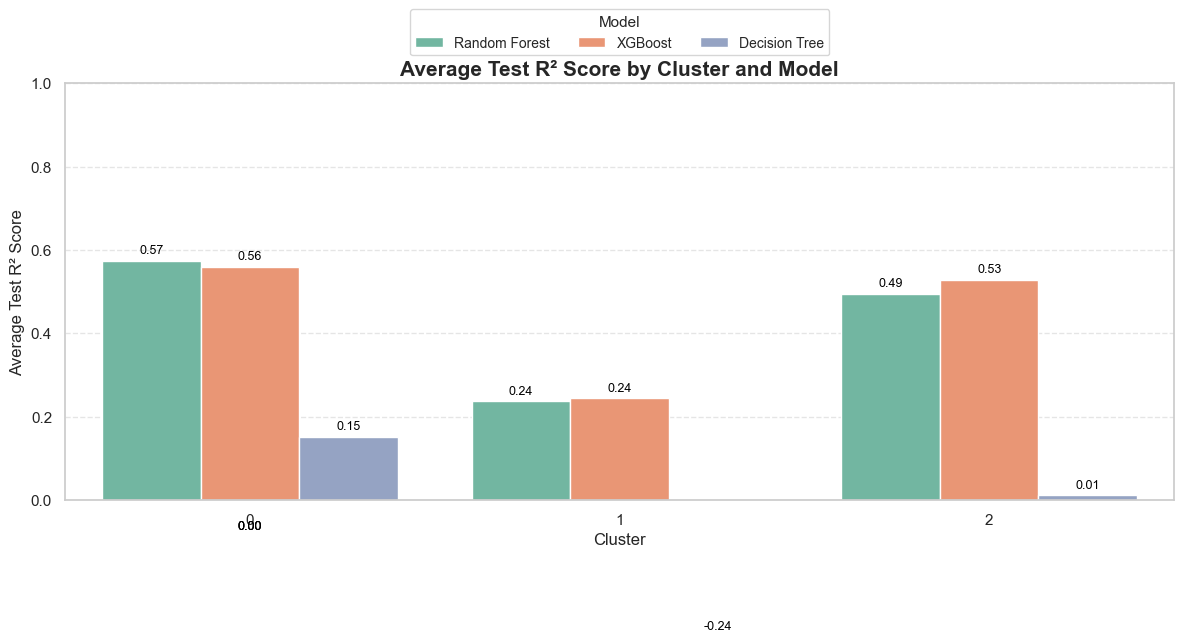

In [32]:


# Prepare data
cluster_avg = results_df.groupby(['Cluster', 'Model'])['Test_R2'].mean().reset_index()

# Sort within cluster by Test_R2
cluster_avg = cluster_avg.sort_values(['Cluster', 'Test_R2'], ascending=[True, False])

# Set aesthetic style
sns.set(style="whitegrid")
palette = sns.color_palette("Set2")

# Create figure
plt.figure(figsize=(12, 7))
ax = sns.barplot(data=cluster_avg, x='Cluster', y='Test_R2', hue='Model', palette=palette)

# Annotate bars
for p in ax.patches:
    h = p.get_height()
    if not pd.isna(h):
        ax.text(
            p.get_x() + p.get_width() / 2,
            h + 0.01 if h > 0 else h - 0.05,
            f"{h:.2f}",
            ha='center', va='bottom' if h > 0 else 'top',
            fontsize=9, color='black'
        )

# Labels and grid
ax.set_title("Average Test R² Score by Cluster and Model", fontsize=15, weight='bold')
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Average Test R² Score", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_ylim(0, 1)  # Optional: adjust based on score range

# Legend positioning
ax.legend(title='Model', bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=len(cluster_avg['Model'].unique()), fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()


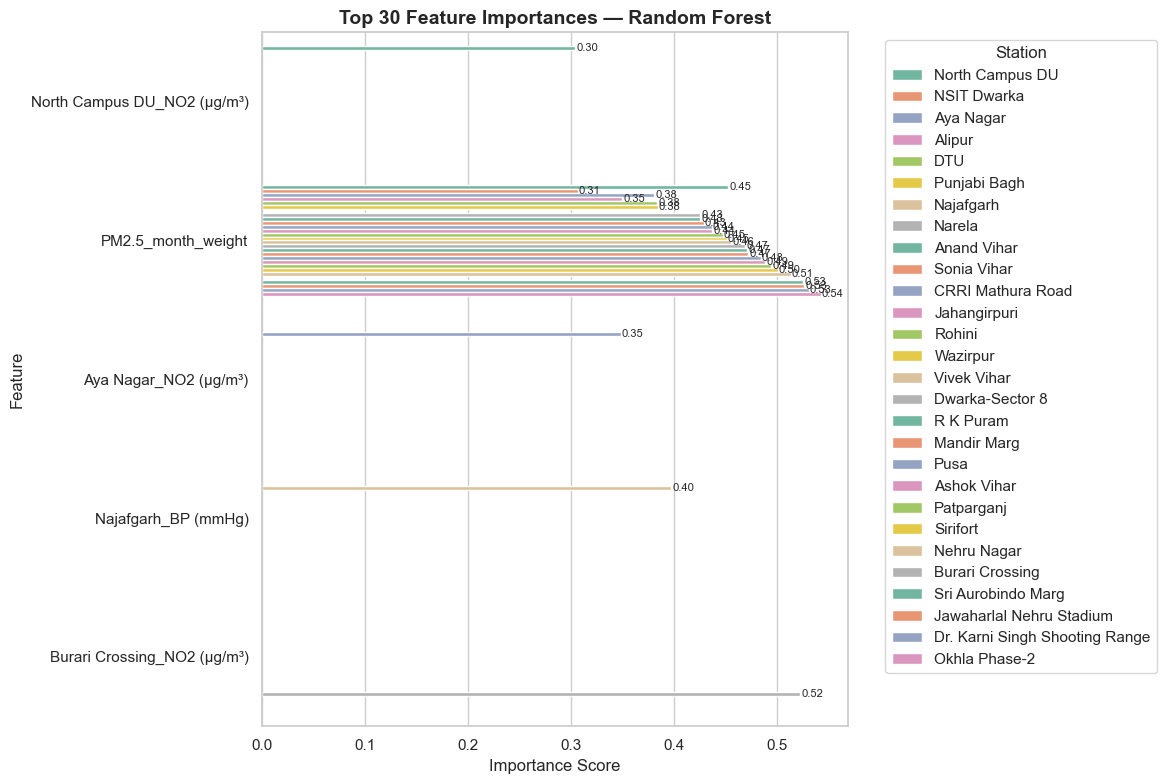

In [33]:


# Combine feature importances
fi_df = pd.concat(all_feature_importance, ignore_index=True)

# Filter for Random Forest only
rf_df = fi_df[fi_df['Model'] == 'Random Forest']

# Take top 30 most important features across all stations
top_rf = rf_df.sort_values(by='Importance', ascending=False).head(30)

# Sort for consistent plot order
top_rf = top_rf.sort_values(by='Importance', ascending=True)

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot
ax = sns.barplot(data=top_rf, x='Importance', y='Feature', hue='Station', palette='Set2')

# Annotate importance values
for p in ax.patches:
    width = p.get_width()
    if width > 0.001:
        ax.text(
            width + 0.001,
            p.get_y() + p.get_height() / 2,
            f"{width:.2f}",
            va='center',
            fontsize=8
        )

# Titles and labels
plt.title("Top 30 Feature Importances — Random Forest", fontsize=14, weight='bold')
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [34]:


filtered_results = []

# Loop through each cluster
for cluster_id in sorted(station_scores['cluster'].unique()):
    stations = station_scores[station_scores['cluster'] == cluster_id]['main_station'].tolist()
    
    for station in stations:
        target_col = f"{station}_PM2.5 (µg/m³)"
        if target_col not in df.columns:
            continue

        # Filter important features for this station
        rf_feats = fi_df[(fi_df['Station'] == station) &
                         (fi_df['Model'] == 'Random Forest') &
                         (fi_df['Importance'] > 0)]

        important_feats = rf_feats['Feature'].tolist()
        if not important_feats:
            continue

        # Create dataset with Timestamp, target, and important features
        df_station = df[['Timestamp', target_col] + important_feats].dropna().sort_values('Timestamp')
        X = df_station.drop(columns=['Timestamp', target_col])
        y = df_station[target_col]

        # Create train/test split
        train_mask = df_station['Timestamp'] < '2024-01-01'
        test_mask = df_station['Timestamp'] >= '2024-01-01'

        X_train, y_train = X[train_mask], y[train_mask]
        X_test, y_test = X[test_mask], y[test_mask]

        # Train model
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train)

        # Predictions
        y_pred_train = rf.predict(X_train)
        y_pred_test = rf.predict(X_test)

        # Store results
        filtered_results.append({
            'Cluster': cluster_id,
            'Station': station,
            'Model': 'Random Forest (Filtered)',
            'Train_R2': r2_score(y_train, y_pred_train),
            'Test_R2': r2_score(y_test, y_pred_test)
        })


In [35]:
filtered_results_df = pd.DataFrame(filtered_results)

# Print results for each cluster
for cluster_id in sorted(filtered_results_df['Cluster'].unique()):
    cluster_data = filtered_results_df[filtered_results_df['Cluster'] == cluster_id]
    
    print(f"\n📊 Cluster {cluster_id} - Filtered Random Forest Performance")
    print("=" * 70)
    print(cluster_data[['Station', 'Train_R2', 'Test_R2']].to_string(index=False,
          formatters={
              'Train_R2': '{:.3f}'.format,
              'Test_R2': '{:.3f}'.format
          }))



📊 Cluster 0 - Filtered Random Forest Performance
                       Station Train_R2 Test_R2
                   Anand Vihar    0.976   0.351
                   Ashok Vihar    0.984   0.558
                        Bawana    0.980   0.549
Dr. Karni Singh Shooting Range    0.980   0.662
               Dwarka-Sector 8    0.980   0.525
                  Jahangirpuri    0.983   0.606
      Jawaharlal Nehru Stadium    0.984   0.589
                   Mandir Marg    0.973   0.562
                     Najafgarh    0.980   0.582
                        Narela    0.981   0.521
                   Nehru Nagar    0.984   0.640
                 Okhla Phase-2    0.986   0.703
                    Patparganj    0.983   0.608
                  Punjabi Bagh    0.975   0.607
                          Pusa    0.976   0.576
                     R K Puram    0.974   0.614
                        Rohini    0.983   0.452
                   Sonia Vihar    0.982   0.533
            Sri Aurobindo Marg    0.98

In [ ]:


# Plot for each cluster separately
for cluster_id in sorted(filtered_results_df['Cluster'].unique()):
    cluster_data = filtered_results_df[filtered_results_df['Cluster'] == cluster_id]

    plt.figure(figsize=(14, 6))
    
    # Melt the DataFrame to long format for seaborn
    melted = cluster_data.melt(id_vars=['Station'], 
                               value_vars=['Train_R2', 'Test_R2'], 
                               var_name='Data Split', 
                               value_name='R² Score')

    sns.barplot(data=melted, x='Station', y='R² Score', hue='Data Split', palette='Set2')
    plt.title(f'Cluster {cluster_id} - Random Forest (Filtered) Train vs Test R² Scores')
    plt.xticks(rotation=90)

    # Annotate each bar with value
    for p in plt.gca().patches:
        height = p.get_height()
        if not pd.isna(height):
            plt.text(p.get_x() + p.get_width() / 2, height + 0.01, f"{height:.2f}", 
                     ha='center', va='bottom', fontsize=9)

    plt.ylabel("R² Score")
    plt.xlabel("Station")
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(title="Data Split", loc='lower right')
    plt.tight_layout()
    plt.show()


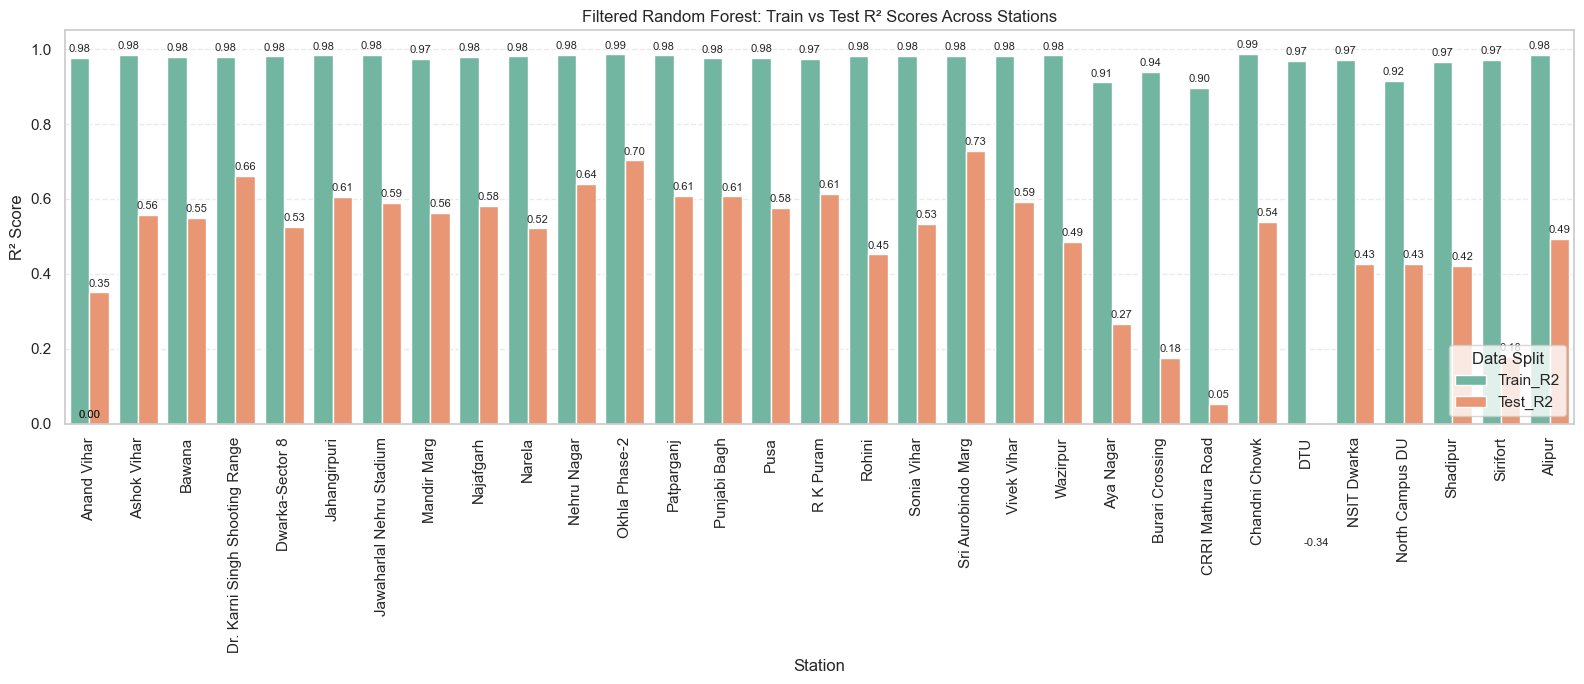

In [36]:


# Melt DataFrame for side-by-side Train and Test scores
melted_df = filtered_results_df.melt(
    id_vars=['Station', 'Cluster'],
    value_vars=['Train_R2', 'Test_R2'],
    var_name='Data Split',
    value_name='R² Score'
)

plt.figure(figsize=(16, 7))
sns.barplot(
    data=melted_df,
    x='Station',
    y='R² Score',
    hue='Data Split',
    palette='Set2',
    dodge=True
)

# Add value annotations
for p in plt.gca().patches:
    height = p.get_height()
    if not pd.isna(height):
        plt.text(
            p.get_x() + p.get_width() / 2,
            height + 0.01,
            f"{height:.2f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

# Additional styling
plt.title("Filtered Random Forest: Train vs Test R² Scores Across Stations")
plt.xticks(rotation=90)
plt.ylabel("R² Score")
plt.xlabel("Station")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Data Split', loc='lower right')
plt.tight_layout()
plt.show()


C:\Users\jains\AppData\Local\Temp\ipykernel_31840\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\jains\AppData\Local\Temp\ipykernel_31840\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\jains\AppData\Local\Temp\ipykernel_31840\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


C:\Users\jains\AppData\Local\Temp\ipykernel_31840\2960620489.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the sam

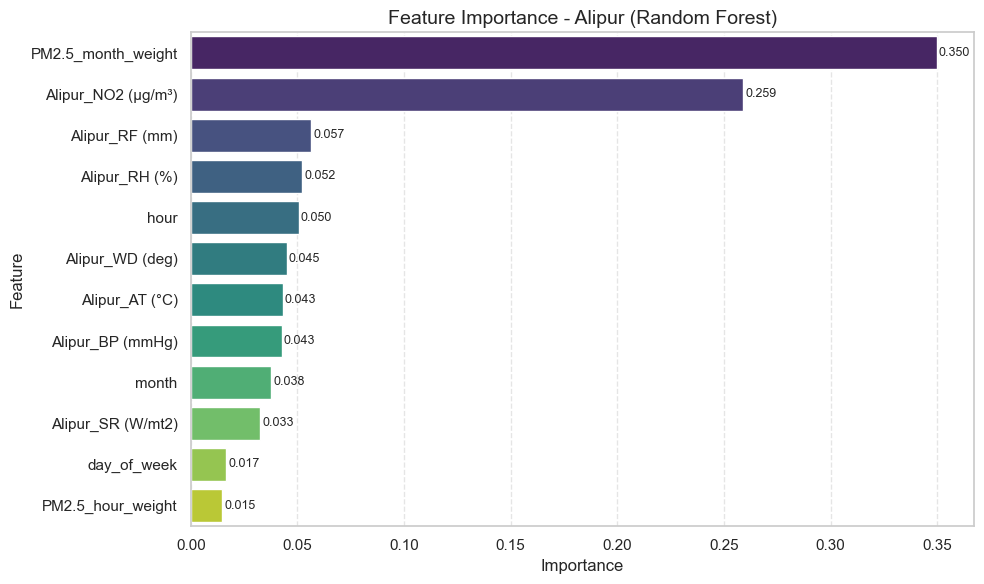

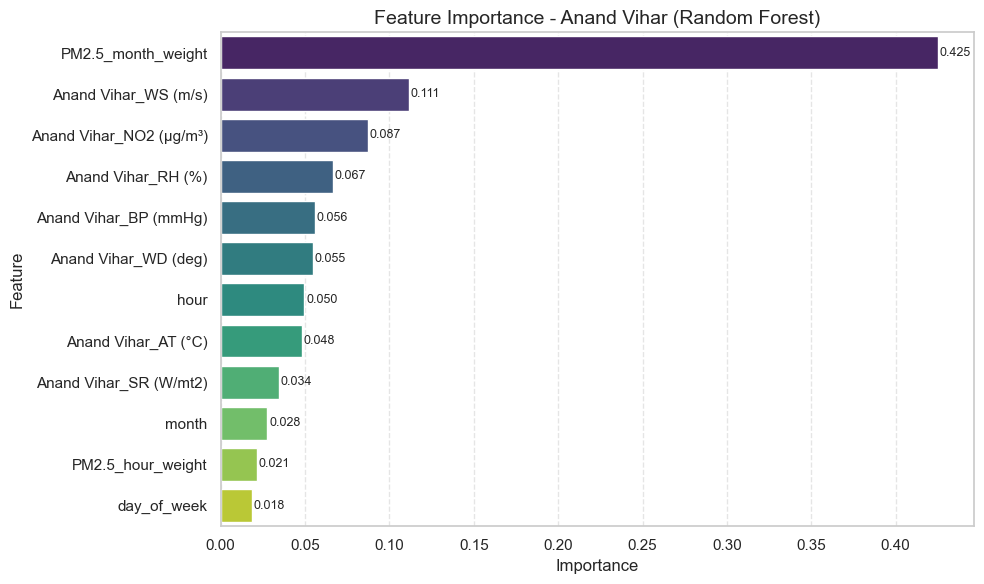

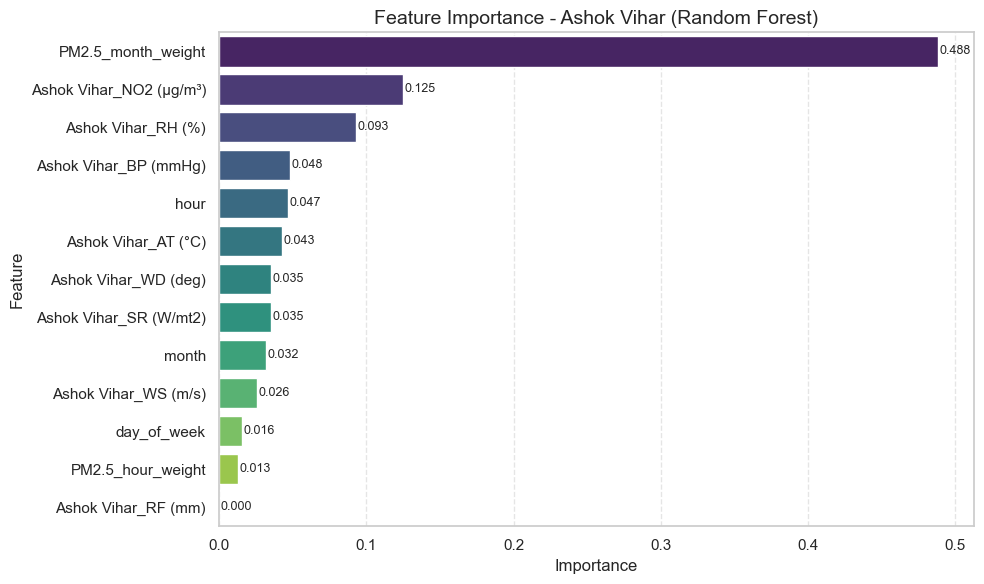

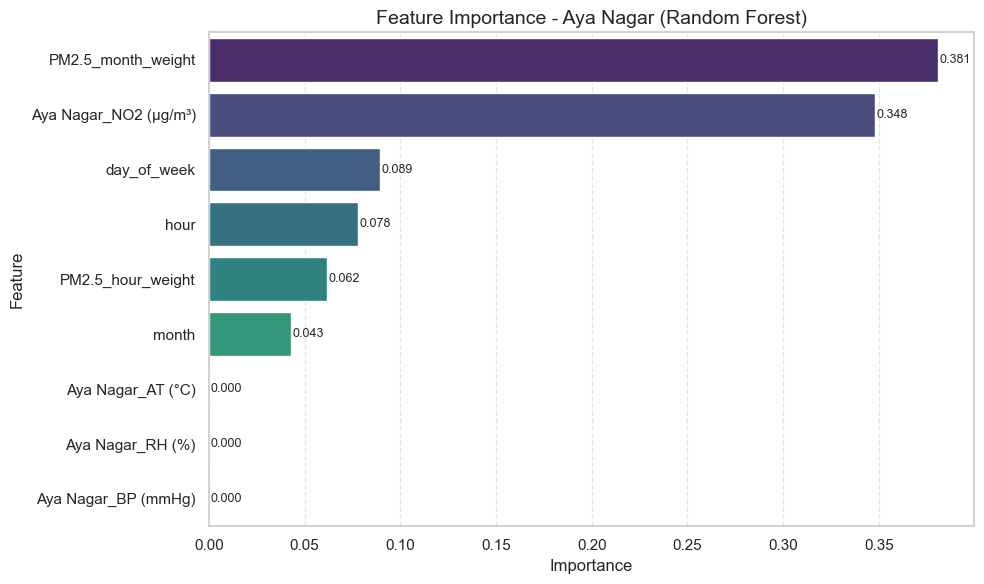

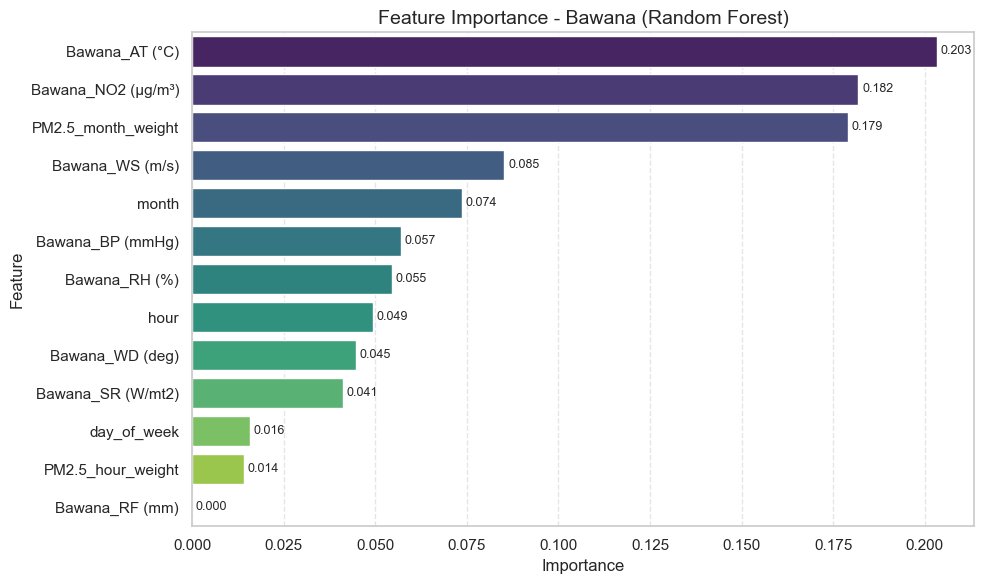

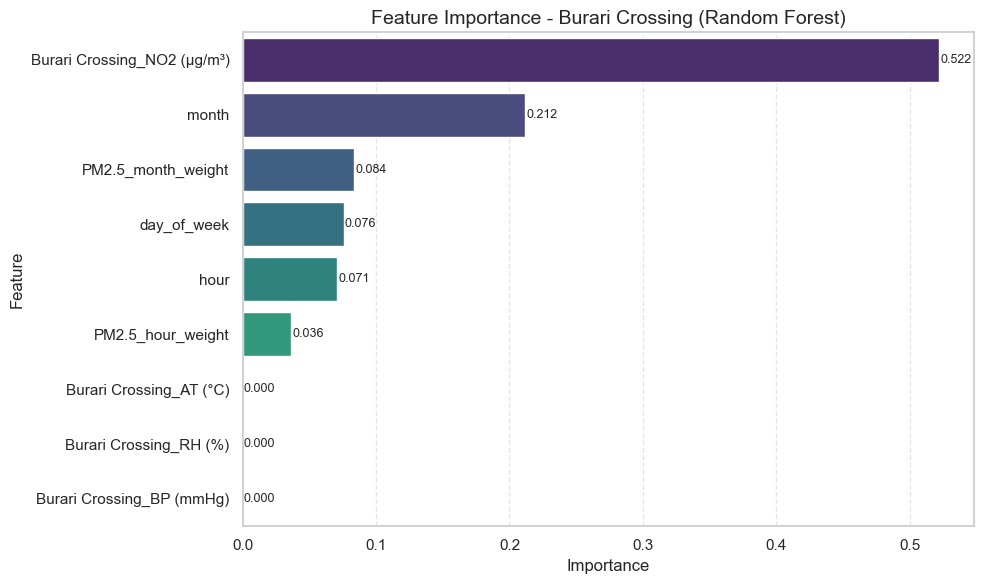

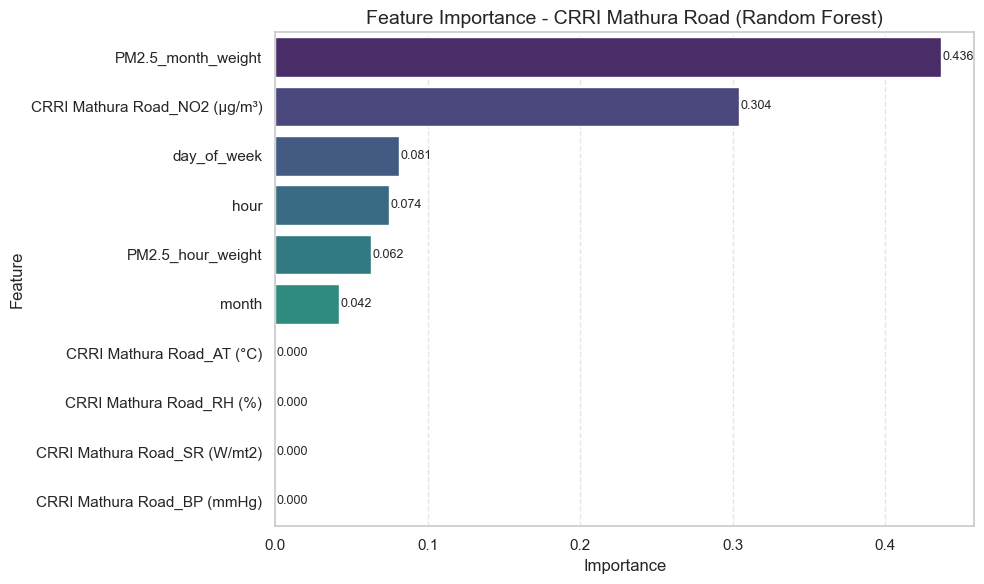

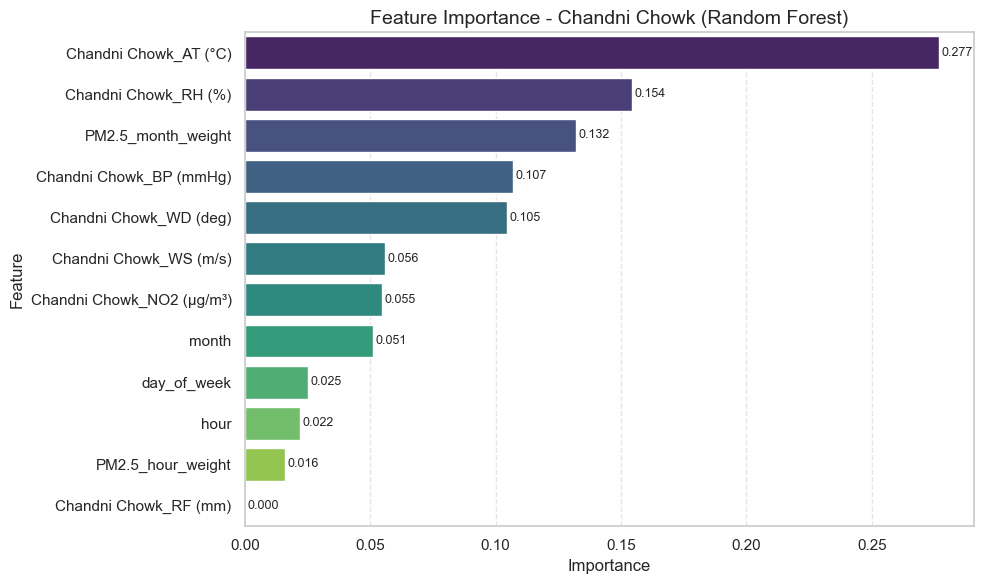

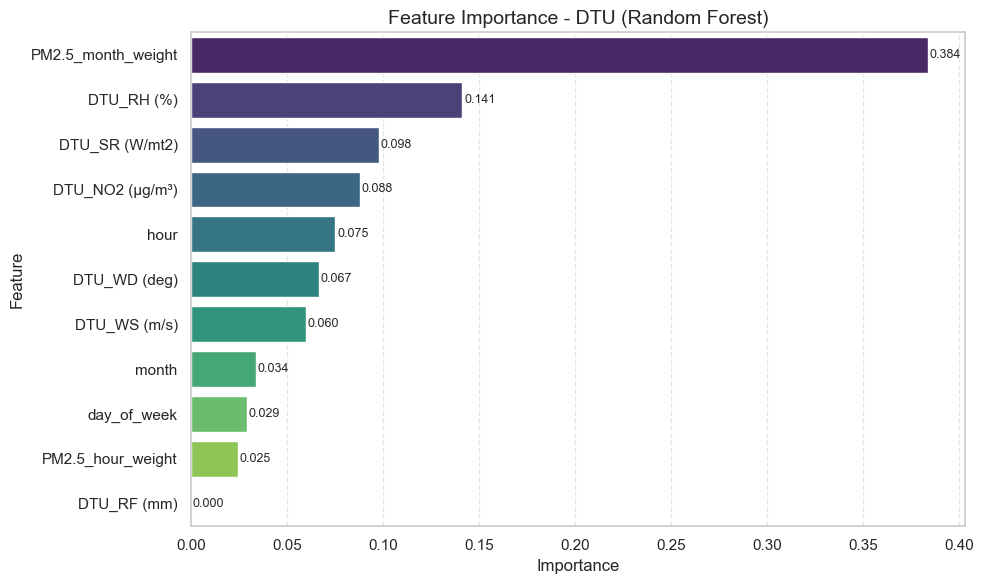

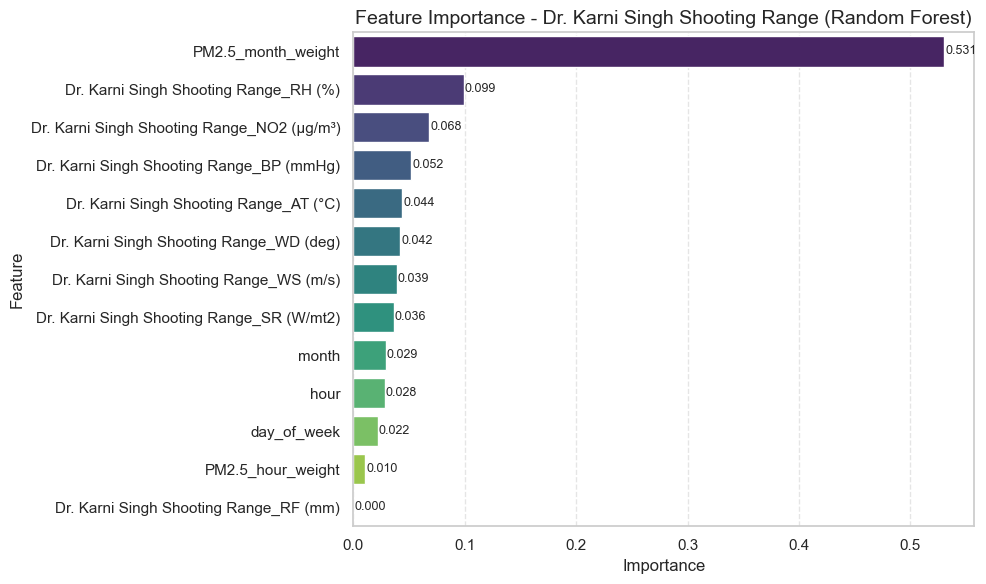

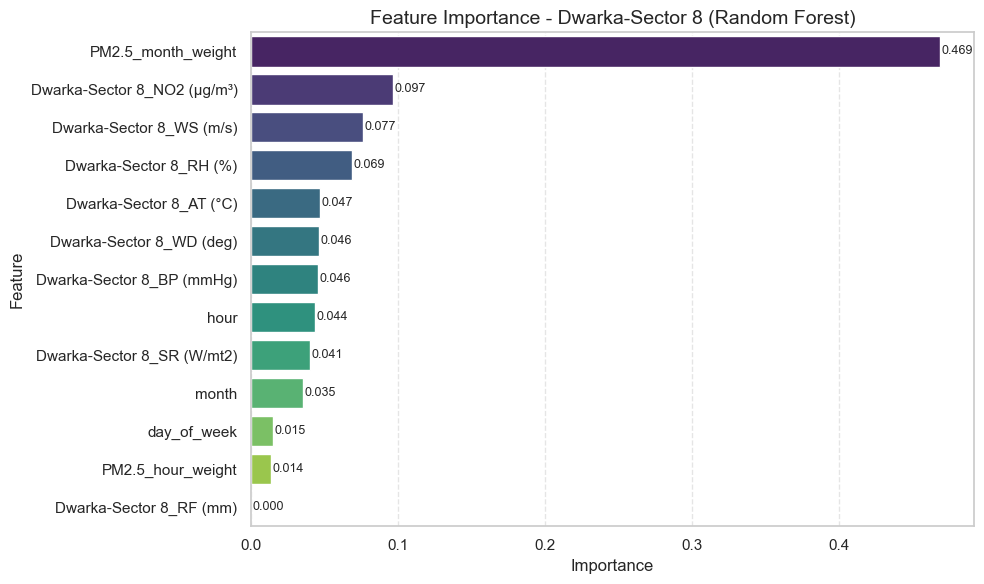

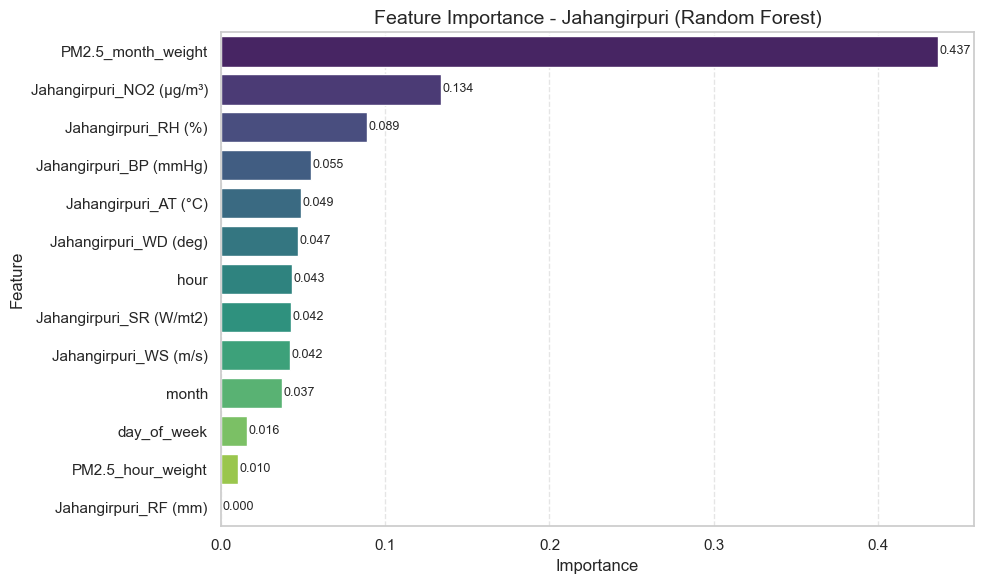

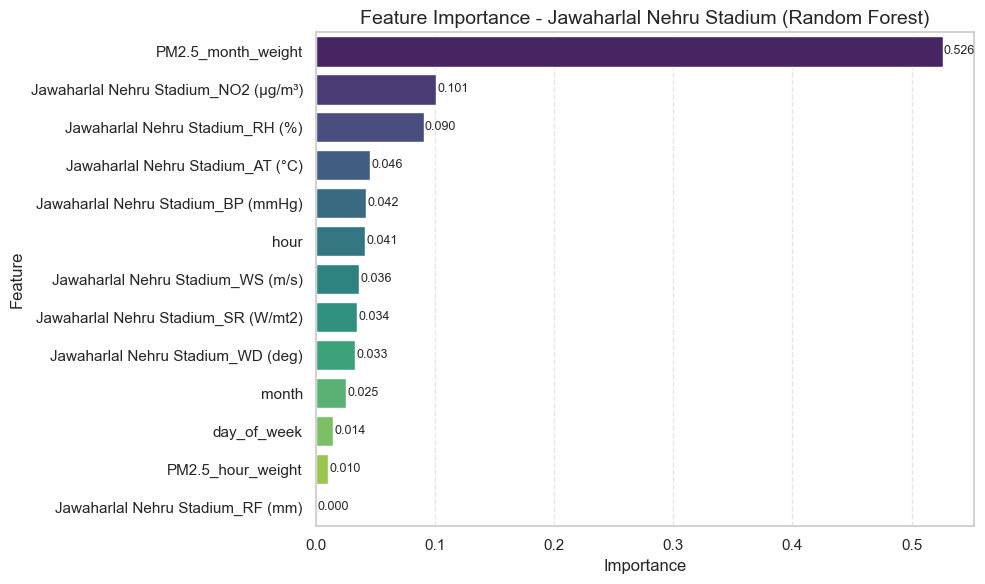

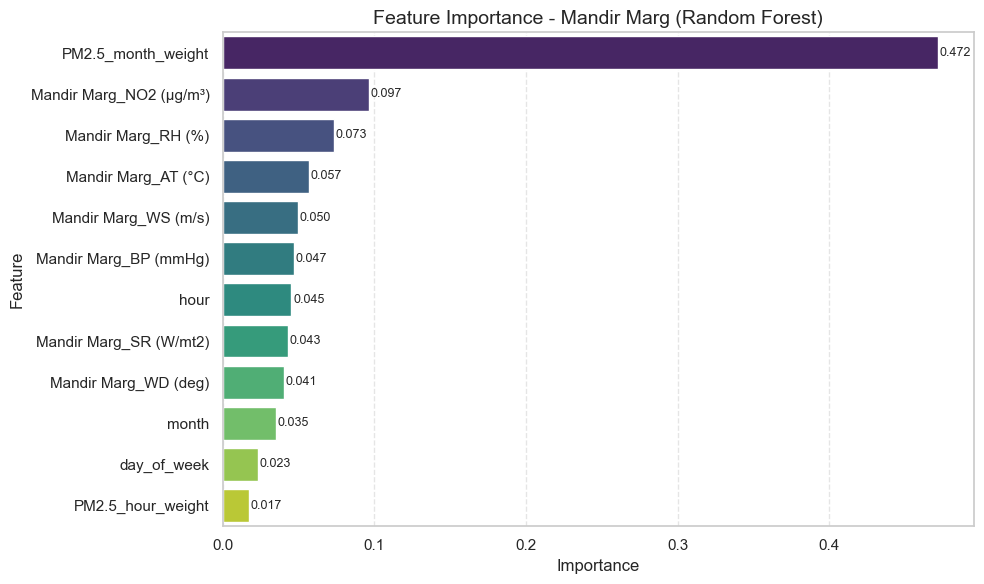

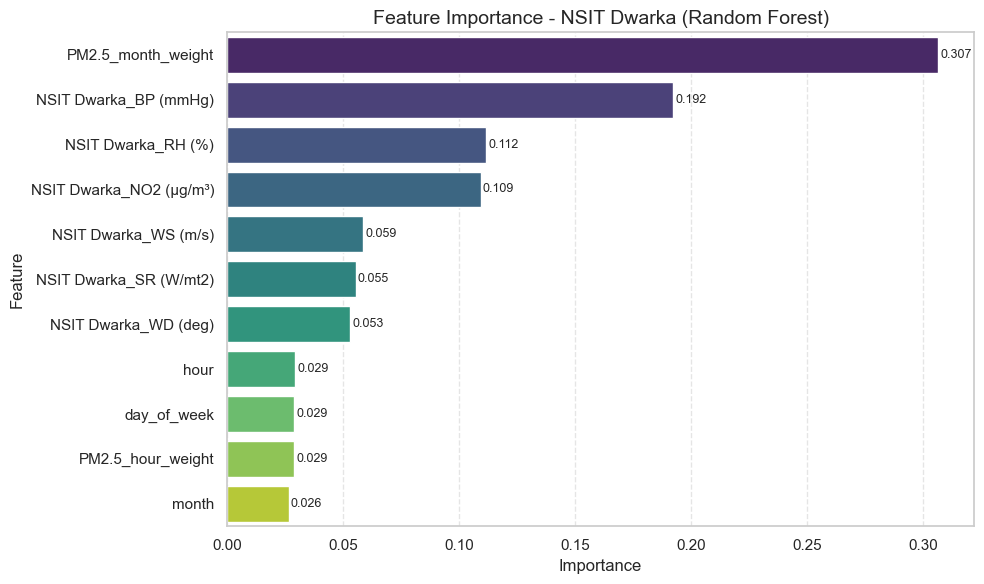

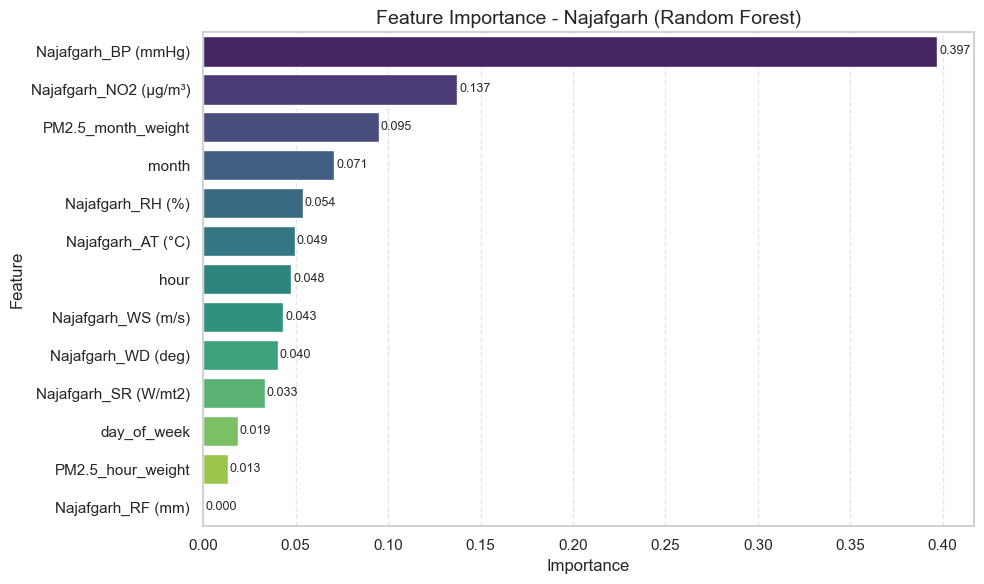

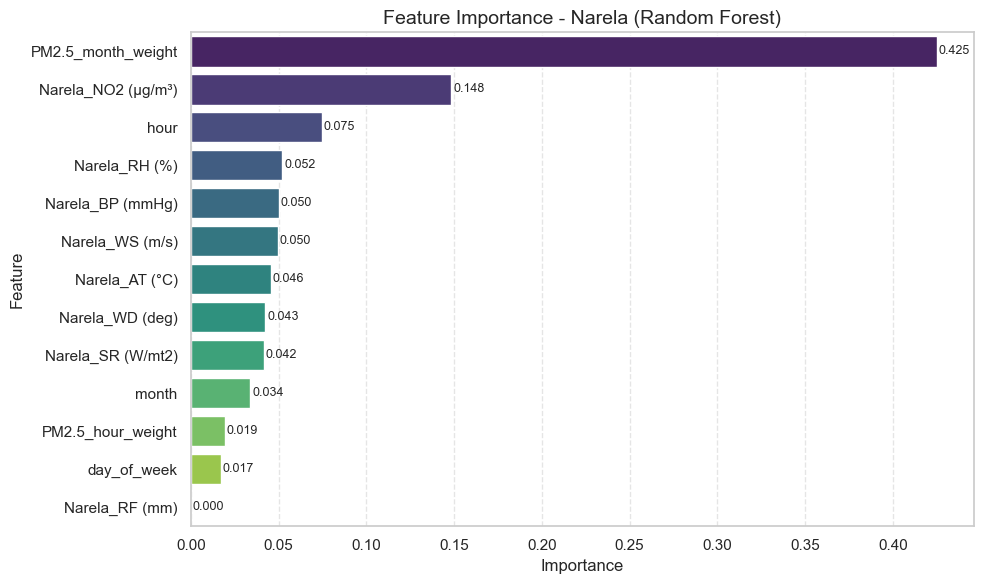

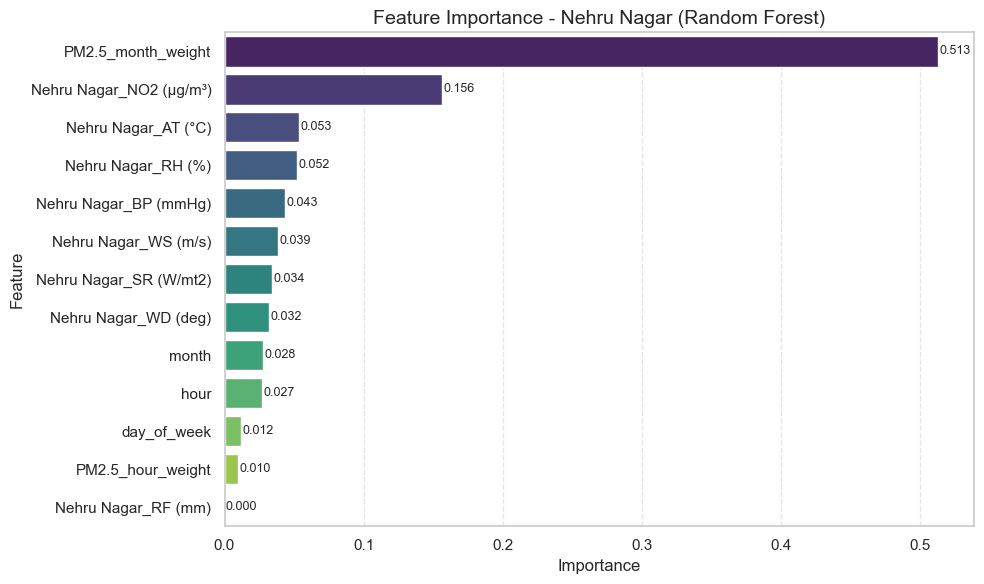

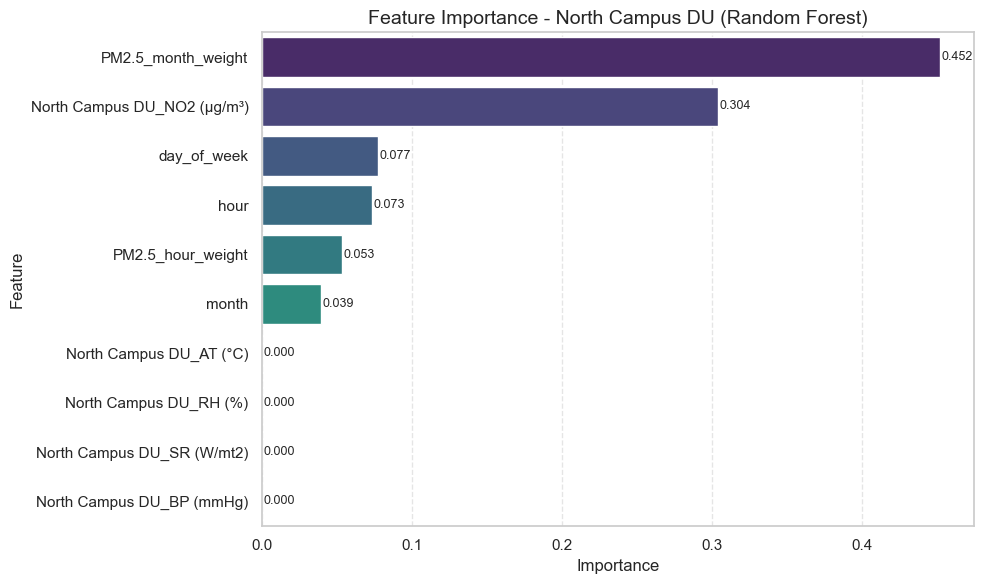

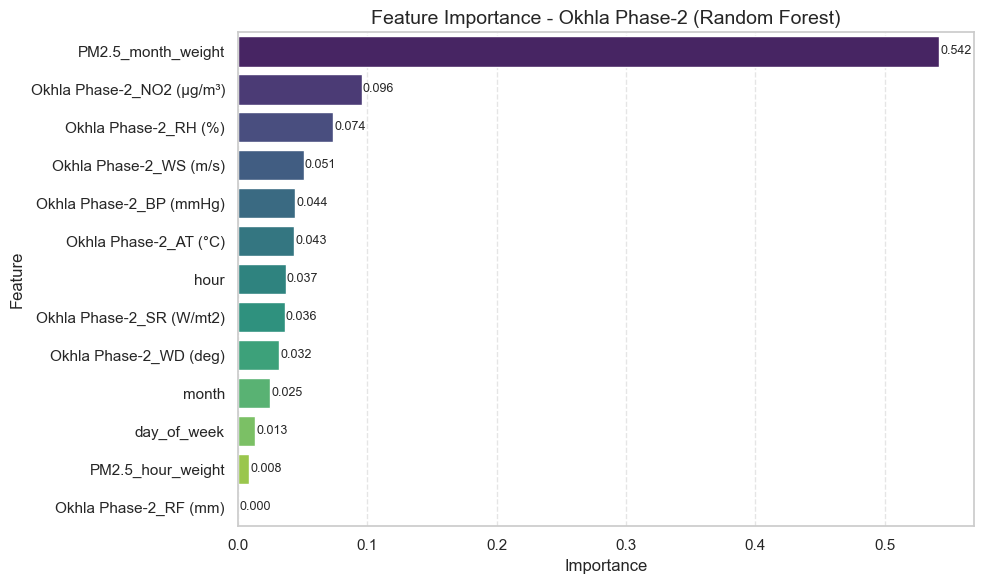

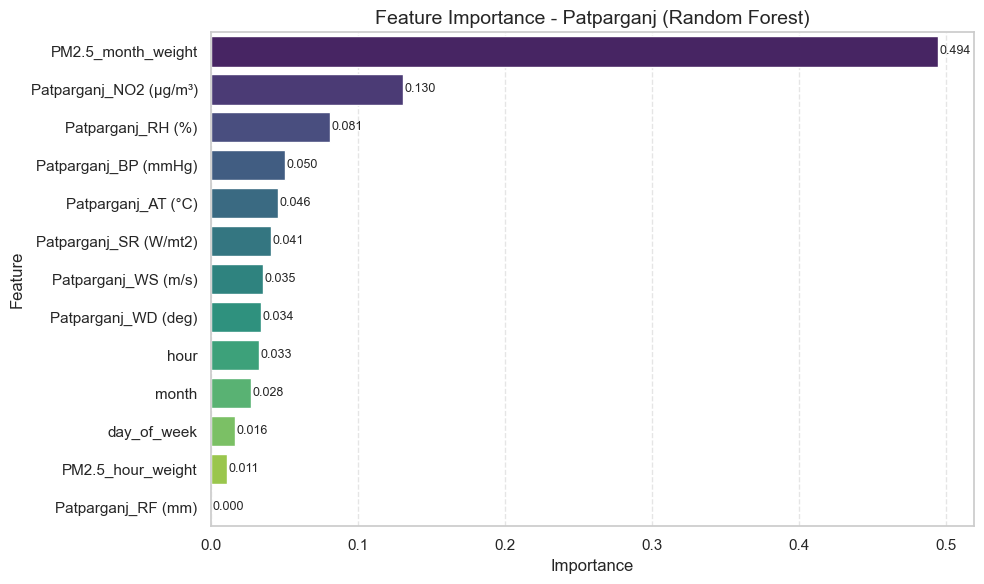

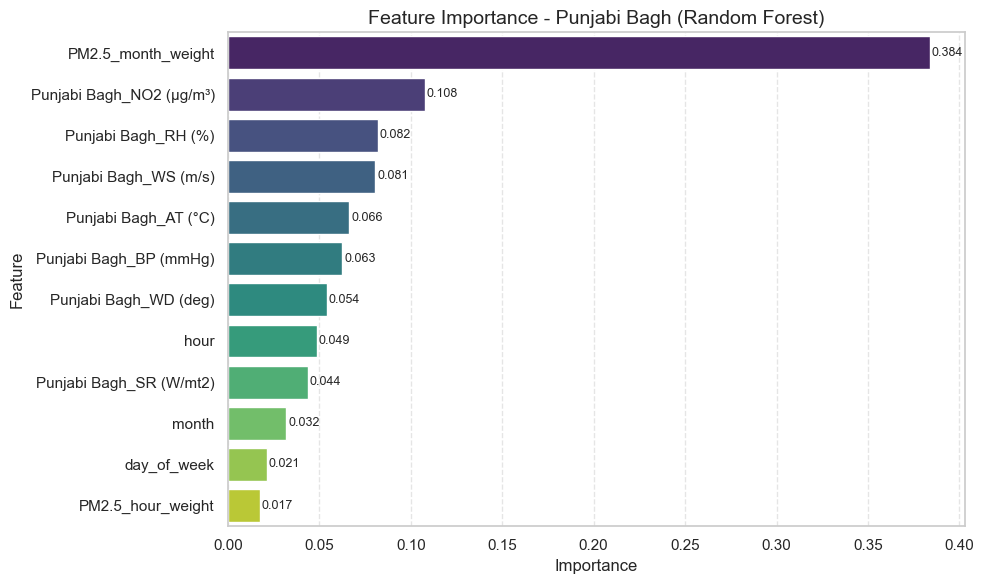

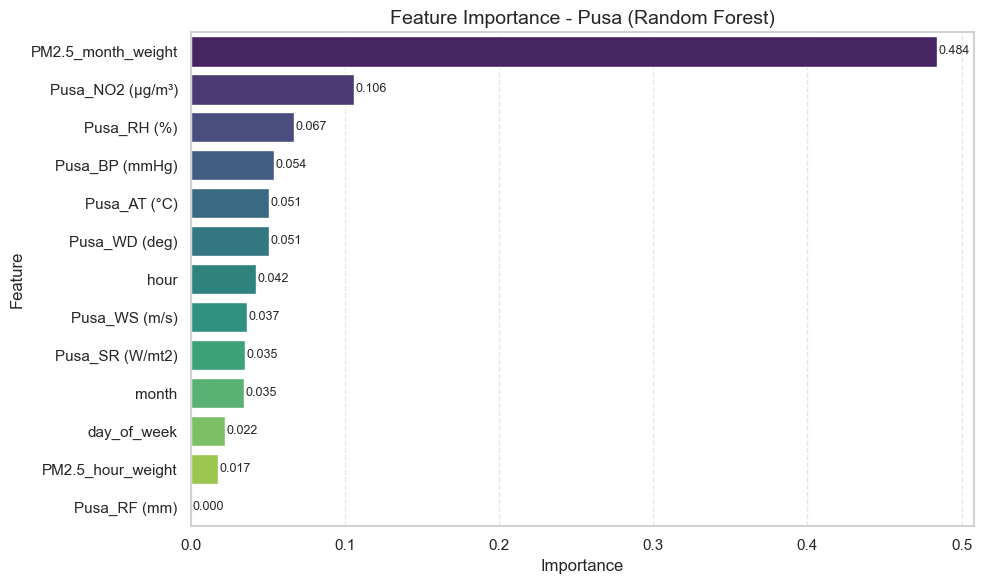

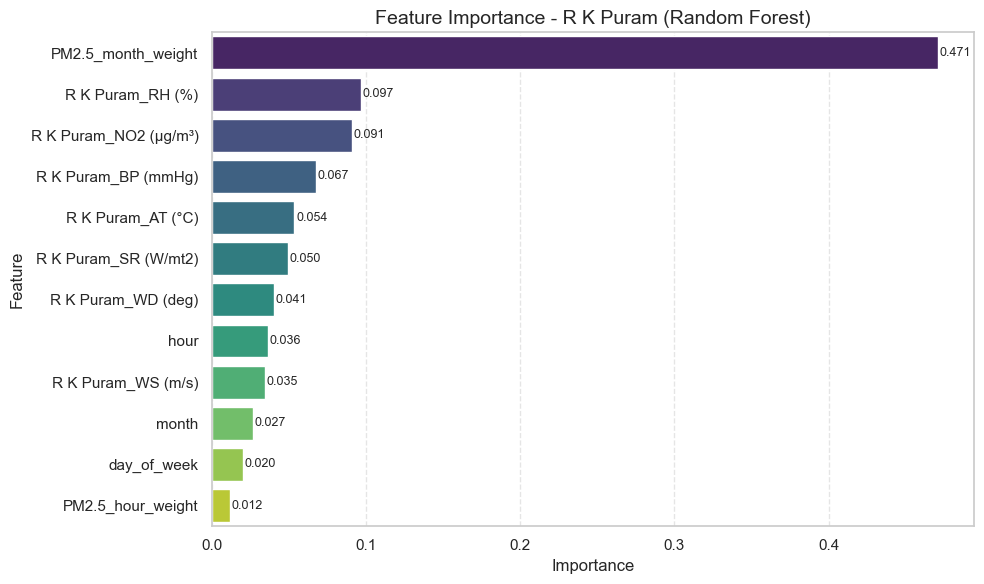

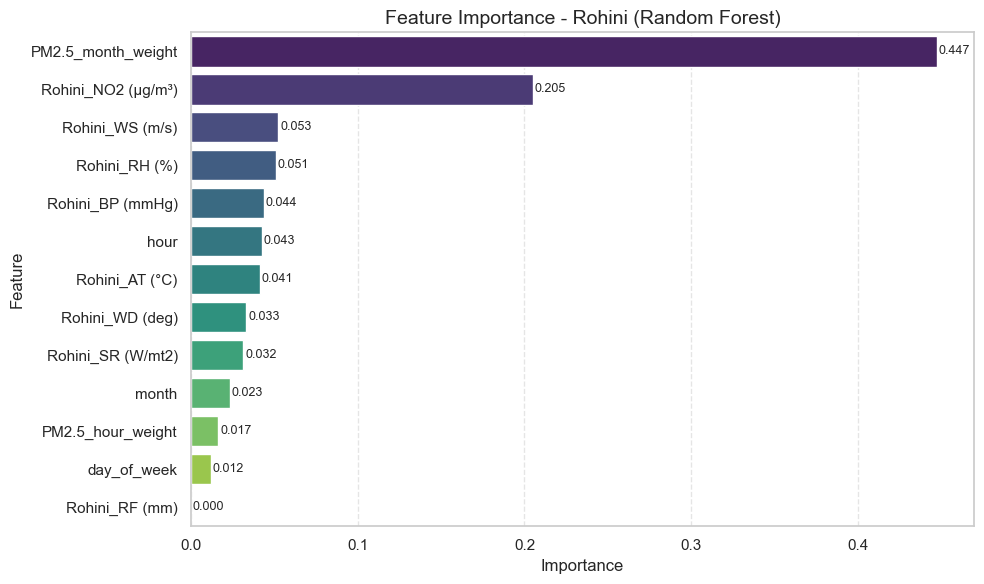

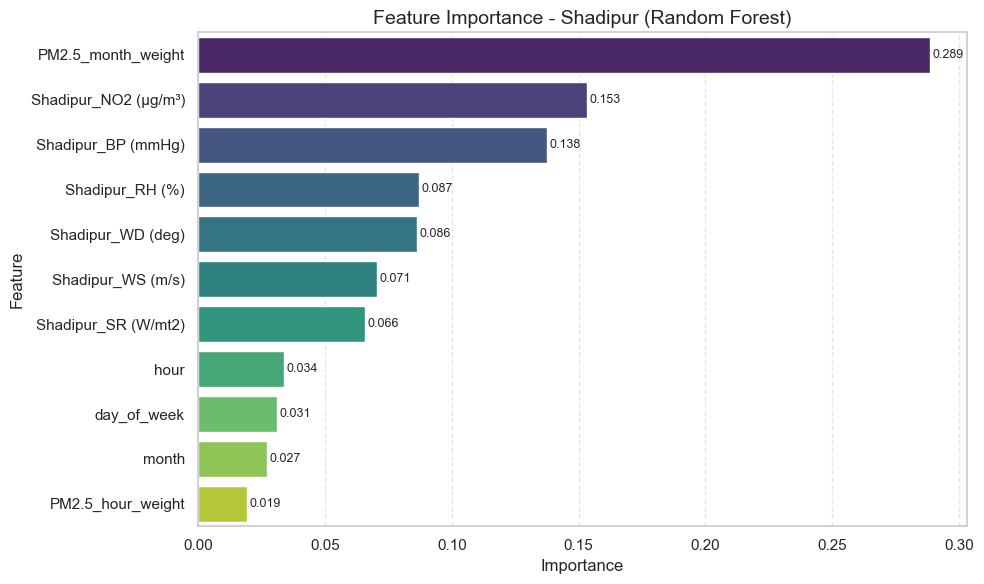

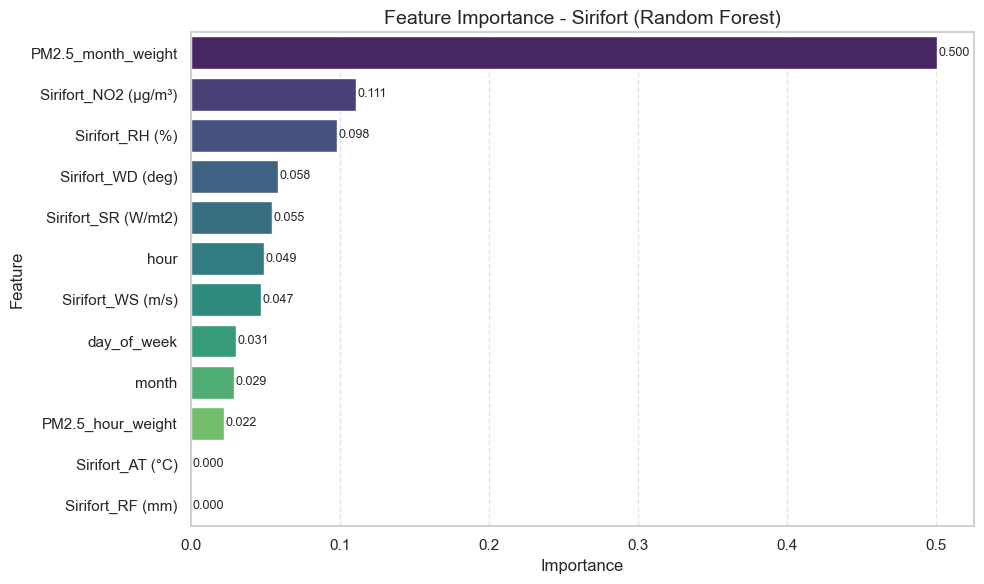

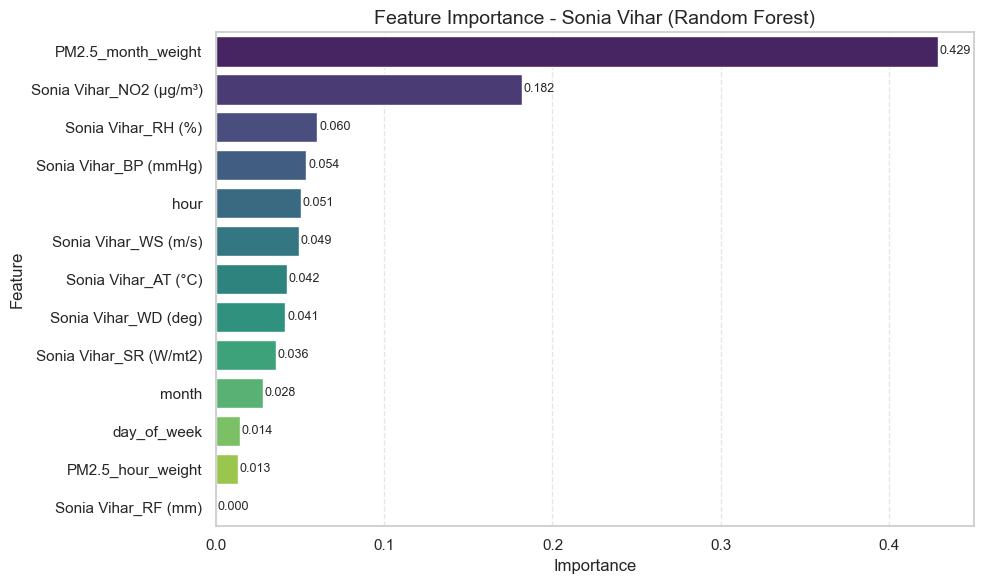

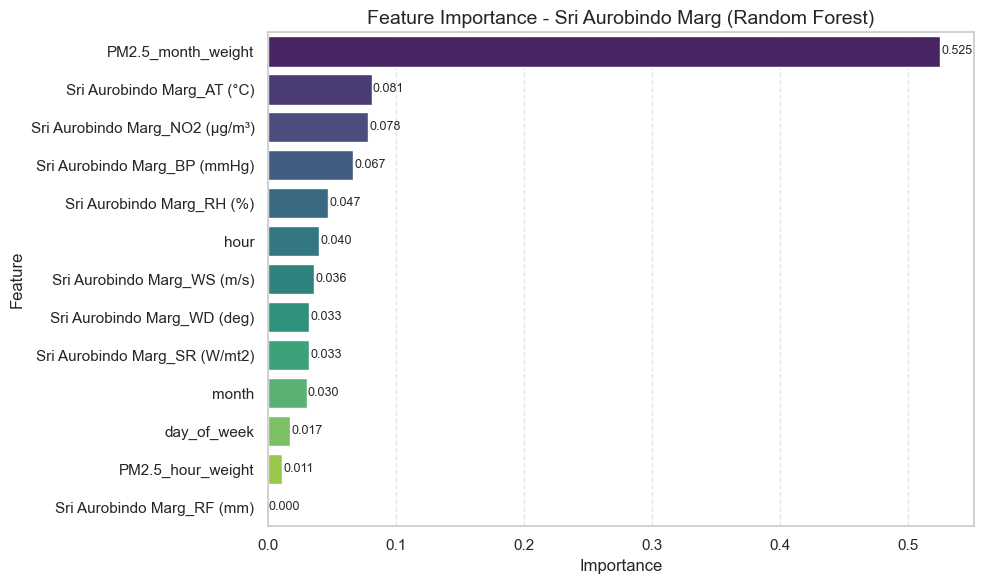

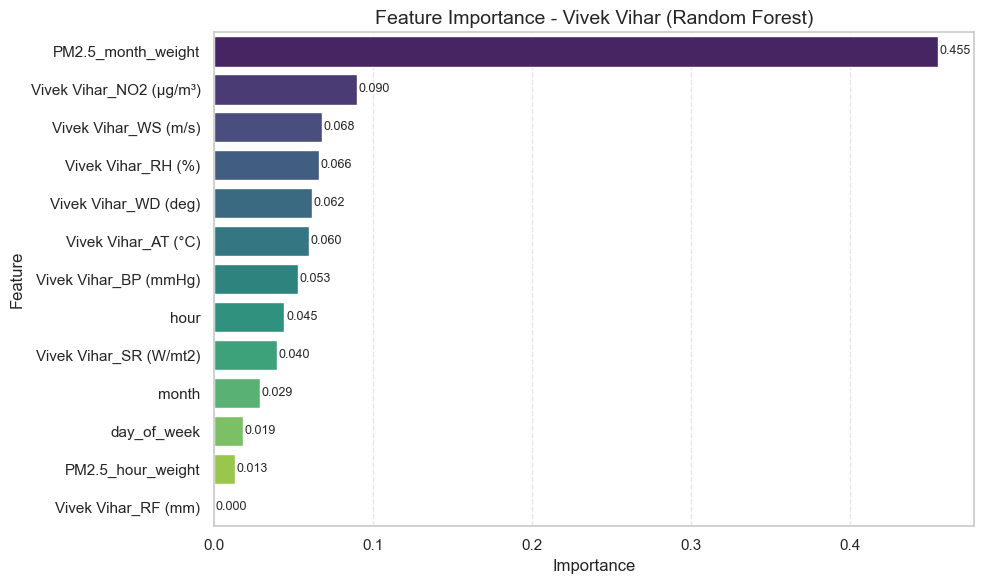

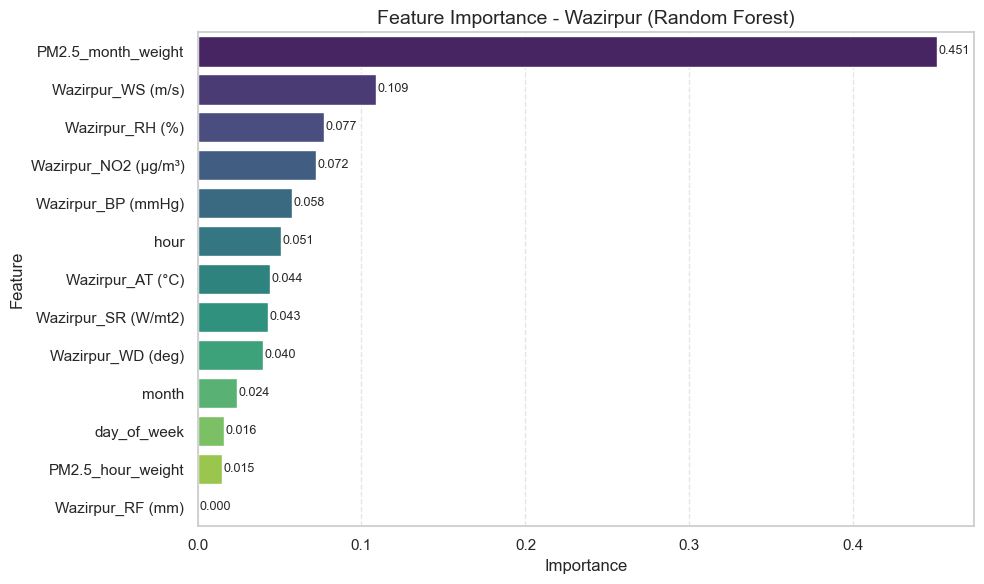

In [37]:
# Assumes fi_df is already created and available
# Filter only Random Forest feature importances
rf_importance_df = fi_df[fi_df['Model'] == 'Random Forest']

# Get unique stations
stations = rf_importance_df['Station'].unique()
for station in sorted(stations):
    station_df = rf_importance_df[rf_importance_df['Station'] == station].copy()
    station_df = station_df.sort_values(by='Importance', ascending=False)

    if station_df.empty or station_df['Importance'].sum() == 0:
        print(f"Skipping {station} - no significant features.")
        continue

    # Take top 15 features only for readability
    station_df = station_df.head(15).reset_index(drop=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=station_df, x='Importance', y='Feature', palette='viridis')

    plt.title(f'Feature Importance - {station} (Random Forest)', fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)

    # Add importance values on bars
    for i, (imp, feat) in enumerate(zip(station_df['Importance'], station_df['Feature'])):
        plt.text(imp + 0.001, i, f"{imp:.3f}", va='center', fontsize=9)

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
